# Filtering out uptake and transfer from my doubling time analyses

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from macrohet import visualise
from tqdm.auto import tqdm
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import r2_score

# Conversion factor
meters_per_pixel = 1.4949402023919043E-07  # Micrometers per pixel
micrometers_per_pixel = meters_per_pixel*1E6 # Micrometers per pixel

# set display params
sns.set(style = 'white')
# Set the default font to Helvetica
mpl.rcParams['font.family'] = 'Nimbus Sans'
# import matplotlib as mpl
# mpl.rcdefaults()
# Get the color palette of the PiYG color map
colours = expanded_piyg = visualise.color_palette('expanded_piyg').colors
sns.set_palette(expanded_piyg)
import tempfile
import napari
import glob
import imageio
import skimage.transform
import shutil

#### Function

In [2]:
def plot(ID, df, save = False, napari = False):
    # Get single-cell trajectory in df format
    sc_df = df[df['ID'] == ID]
    # Drop NaN values specifically from the required columns
    sc_df = sc_df.dropna(subset=['Time Model (hours)', 'Mtb Area Model (µm)', 'Mtb Area Processed (µm)'])
    # Ensure there is temporal order
    sc_df = sc_df.sort_values(by='Time Model (hours)')
    
    # Extract Strain, Compound, and Concentration for the title
    strain, compound, concentration = sc_df[['Strain', 'Compound', 'Concentration']].iloc[0].values
    
    # Calculate the R2 value and skip plotting if R2 < 0.7
    r2 = round(r2_score(sc_df['Mtb Area Processed (µm)'], sc_df['Mtb Area Model (µm)']), 2)
    df.loc[df['ID'] == ID, 'r2'] = r2
    if r2 < 0.7:
        # ill_fitting_curves[ID] = r2
        # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        # df.loc[df['ID'] == ID, 'Doubling Times'] = None
        print(f'Nee fitting ({r2})')
        # return
    
    # Find the temporal order of the minimum and maximum
    min_value = max(sc_df['Mtb Area Model (µm)'].round(1).min(), 1.92) # has to be above the minimum threshold
    max_value = sc_df['Mtb Area Model (µm)'].round(1).max()
    
    # perform a check on the data
    if max_value <= min_value:
        #non_doubling_curves.append(ID)
        print(f'No population doubling for ID {ID}')
    
    # Find the time indices of the minimum and maximum
    min_index = sc_df['Mtb Area Model (µm)'].round(1).idxmin()
    max_index = sc_df['Mtb Area Model (µm)'].round(1).idxmax()
    
    # Check if maximum occurs before minimum
    if max_index > min_index:
        growth = True
        # Minimum occurs before the maximum (indicating growth)
        # Start from the minimum and double
        N_i = min_value
        N_series = []
        
        # Generate the doubling series
        while N_i <= max_value:
            N_series.append(N_i)
            N_i *= 2
        
    else:
        growth = False
        # non_doubling_curves.append(ID)
        print(f'No obvious growth for ID {ID}')
        # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        # df.loc[df['ID'] == ID, 'Doubling Times'] = None
        # return
        # Maximum occurs before the minimum (indicating a reduction)
        # Start from the maximum and halve
        N_i = max_value
        N_series = []
        
        # Generate the halving series
        while N_i >= min_value:
            N_series.append(N_i)
            N_i /= 2
    
    # Check if there are no valid doubling points
    if len(N_series) < 2:
        #non_doubling_curves.append(ID)
        print(f'No population doubling for ID {ID}')
        # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        # df.loc[df['ID'] == ID, 'Doubling Times'] = None
        # return
        
    # Find the indices and corresponding times for each doubling point
    doubling_time_indices = np.clip(np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series), 0, len(sc_df) - 1)
    doubling_time_points = sc_df['Time Model (hours)'].iloc[doubling_time_indices]
    doubling_times = doubling_time_points.diff().dropna().values.tolist()
    
    # if not growth:
    #     doubling_times = [-t for t in doubling_times]
    #     N_series = [-n for n in N_series]  
    
    # Incorporate N_series and doubling_times into the main DataFrame
    # Assign lists to all entries in df with the same ID
    # df.loc[df['ID'] == ID, 'Doubling Amounts'] = df.loc[df['ID'] == ID].apply(lambda x: N_series, axis=1)
    # df.loc[df['ID'] == ID, 'Doubling Times'] = df.loc[df['ID'] == ID].apply(lambda x: doubling_times, axis=1)
    # # df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df_v2.pkl')
        
    # Plot the experimental data and the fitted model
    plt.figure(figsize=(8, 6))
    plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label='Lowess Growth Model', color=colours[-2])
    plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours[0], s=5)
    
    # Annotate doubling times and draw faint lines
    for i, (time, population) in enumerate(zip(doubling_time_points, N_series)):
        time = abs(time)
        population = abs(population)
        color_index = i % len(expanded_piyg)  # This ensures the color index wraps around
        # Draw faint vertical lines at doubling time points
        plt.axvline(x=time, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
        plt.axhline(y=population, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
        
        # Place a text label indicating the doubling time
        if i > 0:  # Start labeling from the second point
            previous_time = doubling_time_points.iloc[i-1]
            
            # Midpoint between the two lines
            label_x_pos = time  # Correct the label position
            # Adjust y-position to place the label just above the horizontal line
            label_y_pos = population + (population * 0.01)  # Slightly above the horizontal line
    
            # Calculate the gap between the lines and scale the font size
            gap = time - previous_time
            scaled_fontsize = max(8, min(12, gap))  # Scale font size within a reasonable range (e.g., 8 to 12)
            
            # Draw the horizontal doubling time label
            plt.text(label_x_pos, label_y_pos, f'{abs(doubling_times[i-1]):.2f}h', 
                     ha='right', va='bottom', alpha=0.5, fontsize=scaled_fontsize, color=expanded_piyg[0])
            
            # Draw vertical arrow showing the change in N_series (doubling amount)
            deltaMtb = population - N_series[i-1]
            
            # Midpoint for the vertical delta annotation
            text_y_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
            text_x_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
    
            # Midpoint between the two lines
            label_x_pos = time + 0.1  # Adjust x-position
            # Adjust y-position to place the label just above the horizontal line
            label_y_pos = population - (max_value * 0.01)
            
            # Place the vertical label using plt.text
            plt.text(label_x_pos, label_y_pos, f'Δ {abs(deltaMtb):.1f}µm²',
                     fontsize=scaled_fontsize, color=expanded_piyg[0], ha='left', va='top', rotation=270, alpha=0.5)
    
    # Add labels, legend, and titles
    plt.xlabel('Time (Hours)')
    plt.ylabel('Mtb Area µm$^{2}$')
    plt.legend()
        # Main title
    plt.suptitle('Single-Macrophage Intracellular Mtb Dynamics', 
                 weight='bold', fontsize=16)
    # Subtitle
    plt.title(f'Cell ID {ID} | Strain: {strain} | Compound: {compound} | Concentration: {concentration} | R² = {r2}', fontsize=12, pad=10)
    
    sns.despine(offset=10)
    plt.grid(False)
    
    if save:    
        plt.savefig(f'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/{ID}_dtmin{np.min(doubling_times)}_r2{r2}_graph.pdf', bbox_inches = 'tight', dpi = 314)
        # plt.close()
    if napari:
        # Save the current plot to a temporary file
        with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp_plot:
            plt.savefig(tmp_plot.name, bbox_inches='tight', dpi=314)
            plot_image_path = tmp_plot.name
        plot_image = imageio.imread(plot_image_path)
        # Resize the plot image to have a width of 750 pixels, maintaining aspect ratio
        height, width = plot_image.shape[:2]
        new_width = 750
        scale_factor = new_width / width
        new_height = int(height * scale_factor)
        resized_plot_image = skimage.transform.resize(plot_image, (new_height, new_width), anti_aliasing=True)
        viewer.add_image(resized_plot_image, name=f'ID: {ID} Plot', )#colormap='gray')
        return doubling_times, N_series
    else:    
        plt.show()

def regen(ID, df):
    # Get single-cell trajectory in df format
    sc_df = df[df['ID'] == ID]
    # Drop NaN values specifically from the required columns
    sc_df = sc_df.dropna(subset=['Time Model (hours)', 'Mtb Area Model (µm)', 'Mtb Area Processed (µm)'])
    # Ensure there is temporal order
    sc_df = sc_df.sort_values(by='Time Model (hours)')
    # Extract Strain, Compound, and Concentration for the title
    strain, compound, concentration = sc_df[['Strain', 'Compound', 'Concentration']].iloc[0].values
    # Calculate the R2 value and skip plotting if R2 < 0.7
    r2 = round(r2_score(sc_df['Mtb Area Processed (µm)'], sc_df['Mtb Area Model (µm)']), 2)
    df.loc[df['ID'] == ID, 'r2'] = r2
    if r2 < 0.7:
        # ill_fitting_curves[ID] = r2
        df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        df.loc[df['ID'] == ID, 'Doubling Times'] = None
        print(f'Nee fitting ({r2})')
        return
    
    # Find the temporal order of the minimum and maximum
    min_value = max(sc_df['Mtb Area Model (µm)'].round(1).min(), 1.92) # has to be above the minimum threshold
    max_value = sc_df['Mtb Area Model (µm)'].round(1).max()
    
    # perform a check on the data
    if max_value <= min_value:
        print(f'No population doubling for ID {ID}')
    
    # Find the time indices of the minimum and maximum
    min_index = sc_df['Mtb Area Model (µm)'].round(1).idxmin()
    max_index = sc_df['Mtb Area Model (µm)'].round(1).idxmax()
    
    # Check if maximum occurs before minimum
    if max_index > min_index:
        growth = True
        # Minimum occurs before the maximum (indicating growth)
        N_i = min_value
        N_series = []
        
        # Generate the doubling series
        while N_i <= max_value:
            N_series.append(N_i)
            N_i *= 2
        
    else:
        growth = False
        print(f'No obvious growth for ID {ID}')
        df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        df.loc[df['ID'] == ID, 'Doubling Times'] = None
        return
    
    # Check if there are no valid doubling points
    if len(N_series) < 2:
        print(f'No population doubling for ID {ID}')
        df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        df.loc[df['ID'] == ID, 'Doubling Times'] = None
        return
        
    # Find the indices and corresponding times for each doubling point
    doubling_time_indices = np.clip(np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series), 0, len(sc_df) - 1)
    doubling_time_points = sc_df['Time Model (hours)'].iloc[doubling_time_indices]
    doubling_times = doubling_time_points.diff().dropna().values.tolist()
    
    # Incorporate N_series and doubling_times into the main DataFrame
    df.loc[df['ID'] == ID, 'Doubling Amounts'] = df.loc[df['ID'] == ID].apply(lambda x: N_series, axis=1)
    df.loc[df['ID'] == ID, 'Doubling Times'] = df.loc[df['ID'] == ID].apply(lambda x: doubling_times, axis=1)
        
    # Plot the experimental data and the fitted model
    plt.figure(figsize=(8, 6))
    plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label='Lowess Growth Model', color=colours[-2])
    plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours[0], s=5)
    
    # Annotate doubling times and draw faint lines
    for i, (time, population) in enumerate(zip(doubling_time_points, N_series)):
        time = abs(time)
        population = abs(population)
        color_index = i % len(expanded_piyg)  # This ensures the color index wraps around
        # Draw faint vertical lines at doubling time points
        plt.axvline(x=time, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
        plt.axhline(y=population, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
        
        # Place a text label indicating the doubling time
        if i > 0:  # Start labeling from the second point
            previous_time = doubling_time_points.iloc[i-1]
            
            # Midpoint between the two lines
            label_x_pos = time  # Correct the label position
            # Adjust y-position to place the label just above the horizontal line
            label_y_pos = population + (population * 0.01)  # Slightly above the horizontal line
    
            # Calculate the gap between the lines and scale the font size
            gap = time - previous_time
            scaled_fontsize = max(8, min(12, gap))  # Scale font size within a reasonable range (e.g., 8 to 12)
            
            # Draw the horizontal doubling time label
            plt.text(label_x_pos, label_y_pos, f'{abs(doubling_times[i-1]):.2f}h', 
                     ha='right', va='bottom', alpha=0.5, fontsize=scaled_fontsize, color=expanded_piyg[0])
            
            # Draw vertical arrow showing the change in N_series (doubling amount)
            deltaMtb = population - N_series[i-1]
            
            # Midpoint for the vertical delta annotation
            text_y_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
            text_x_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
    
            # Midpoint between the two lines
            label_x_pos = time + 0.1  # Adjust x-position
            # Adjust y-position to place the label just above the horizontal line
            label_y_pos = population - (max_value * 0.01)
            
            # Place the vertical label using plt.text
            plt.text(label_x_pos, label_y_pos, f'Δ {abs(deltaMtb):.1f}µm²',
                     fontsize=scaled_fontsize, color=expanded_piyg[0], ha='left', va='top', rotation=270, alpha=0.5)
    
    # Add labels, legend, and titles
    plt.xlabel('Time (Hours)')
    plt.ylabel('Mtb Area µm$^{2}$')
    plt.legend()
    # Main title
    plt.suptitle('Single-Macrophage Intracellular Mtb Dynamics', 
                 weight='bold', fontsize=16)
    # Subtitle
    plt.title(f'Cell ID {ID} | Strain: {strain} | Compound: {compound} | Concentration: {concentration} | R² = {r2}', fontsize=12, pad=10)
    
    sns.despine(offset=10)
    plt.grid(False)

    previous_fn = glob.glob(f'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/{ID}_dtmin*.pdf')[0]
    archive_dir = f'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx'
    if previous_fn:
        # Move the file to the archive directory
        shutil.move(previous_fn, os.path.join(archive_dir, os.path.basename(previous_fn)))
        print(f"Moved {previous_fn} to {archive_dir}")
    
    plt.savefig(f'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/{ID}_dtmin{np.min(doubling_times)}_r2{r2}_graph.pdf', bbox_inches = 'tight', dpi = 314)
    plt.close()

## Load params and data

In [4]:
output_dir = '/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/ND4_graphs'#/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480/'#'/Users/dayn/data/macrohet_mac/temp_results/'#
os.makedirs(output_dir, exist_ok = True)

In [5]:
# dt_df= pd.read_pickle('/mnt/SYNO/macrohet_syno/results/dfs/arx/dt_df.pkl')
df = pd.read_pickle('/mnt/SYNO/macrohet_syno/results/dfs/ND4_sc_df.pkl') #sc_df.pkl')
df

Time (hours)  Mtb Area (µm)  dMtb Area (µm)  Mphi Area (µm)  \
0                0.0       0.000000        0.000000     1430.122786   
1                0.5       0.000000        0.000000     1553.352206   
2                1.0       0.000000        0.000000     2206.284874   
3                1.5            NaN        0.000000             NaN   
4                2.0       0.000000        0.000000      806.824178   
...              ...            ...             ...             ...   
802672          74.5      95.562024      -38.908672      945.518734   
802673          75.0      94.623388      -38.908672     1361.825886   
802674          75.5      83.091582      -38.908672     1152.510190   
802675          76.0      77.750300      -38.908672     1126.139005   
802676          76.5      75.448408      -38.908672     1091.990555   

        dMphi Area (µm)  Infection Status  Initial Infection Status  \
0           -684.600439               0.0                       0.0   
1           -684.600439               0.0                       0.0   
2           -684.600439               0.0                       0.0   
3           -684.600439               NaN                       0.0   
4           -684.600439               0.0                       0.0   
...                 ...               ...                       ...   
802672     -1344.930448               1.0                       1.0   
802673     -1344.930448               1.0                       1.0   
802674     -1344.930448               1.0                       1.0   
802675     -1344.930448               1.0                       1.0   
802676     -1344.930448               1.0                       1.0   

        Final Infection Status           x           y  ...  Concentration  \
0                          0.0  535.972046   36.392685  ...            EC0   
1                          0.0  517.281433   31.998940  ...            EC0   
2                          0.0  503.972534   27.664877  ...            EC0   
3                          0.0  493.696564   22.767044  ...            EC0   
4                          0.0  477.338898   15.456922  ...            EC0   
...                        ...         ...         ...  ...            ...   
802672                     1.0  432.996796  159.980438  ...           EC99   
802673                     1.0  433.311157  166.972198  ...           EC99   
802674                     1.0  435.046844  160.506119  ...           EC99   
802675                     1.0  433.829651  157.600281  ...           EC99   
802676                     1.0  434.416290  160.347900  ...           EC99   

        Cell ID  Acquisition ID  Experiment ID  Unique ID                ID  \
0           282          (3, 1)         ND0004    282.3.1    282.3.1.ND0004   
1           282          (3, 1)         ND0004    282.3.1    282.3.1.ND0004   
2           282          (3, 1)         ND0004    282.3.1    282.3.1.ND0004   
3           282          (3, 1)         ND0004    282.3.1    282.3.1.ND0004   
4           282          (3, 1)         ND0004    282.3.1    282.3.1.ND0004   
...         ...             ...            ...        ...               ...   
802672     5015         (6, 12)         ND0004  5015.6.12  5015.6.12.ND0004   
802673     5015         (6, 12)         ND0004  5015.6.12  5015.6.12.ND0004   
802674     5015         (6, 12)         ND0004  5015.6.12  5015.6.12.ND0004   
802675     5015         (6, 12)         ND0004  5015.6.12  5015.6.12.ND0004   
802676     5015         (6, 12)         ND0004  5015.6.12  5015.6.12.ND0004   

       Mtb Area Processed (µm) Time Model (hours) Mtb Area Model (µm)  Frame  
0                          NaN                NaN                 NaN    0.0  
1                          NaN                NaN                 NaN    1.0  
2                          NaN                NaN                 NaN    2.0  
3                          NaN                NaN                 NaN    3.0  
4                    

In [15]:
df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/ND4_sc_df.pkl')

# First, recalculate the doubling times based on new models

In [6]:
len(df['ID'].unique())

7786

In [7]:
df.keys()

Index(['Time (hours)', 'Mtb Area (µm)', 'dMtb Area (µm)', 'Mphi Area (µm)',
       'dMphi Area (µm)', 'Infection Status', 'Initial Infection Status',
       'Final Infection Status', 'x', 'y', 'GFP', 'RFP', 'Eccentricity', 'MSD',
       'Technical Replicate', 'Biological Replicate', 'Strain', 'Compound',
       'Concentration', 'Cell ID', 'Acquisition ID', 'Experiment ID',
       'Unique ID', 'ID', 'Mtb Area Processed (µm)', 'Time Model (hours)',
       'Mtb Area Model (µm)', 'Frame'],
      dtype='object')

In [8]:
# Define the function to check if a cell is an edge cell based on its coordinates and area
def is_edge_cell(row):
    # Calculate the safe margin for the current row's area
    safe_margin = 60 #calculate_safe_margin(row['Mphi Area (µm)']) 
    
    # Calculate the bounding box limits
    x_min, x_max = 0, 1200
    y_min, y_max = 0, 1200
    
    # Check if the cell's coordinates are within the safe margin from the edge
    near_left_edge = row['x'] <= x_min + safe_margin
    near_right_edge = row['x'] >= x_max - safe_margin
    near_bottom_edge = row['y'] <= y_min + safe_margin
    near_top_edge = row['y'] >= y_max - safe_margin
    
    return near_left_edge or near_right_edge or near_bottom_edge or near_top_edge

# Apply the function to determine edge cells for each row in the DataFrame
df['Edge Status'] = df.apply(is_edge_cell, axis=1)

### We are only really intested in the grouwth rates of Mtb in cells that either are infected or become infected 
i.e. Final Infection Status = True

In [9]:
infected_df = df[(df['Final Infection Status'] == True) # check all values are from finally infected cells
                # & (df.groupby('ID')['mtb_origin'].transform(lambda x: x.isna().all())) # check all values of mtb_origin for an ID are unknown (meaning it is genuine intracellular growth)
                & ~(df.groupby('ID')['Edge Status'].transform('any'))
] # check all values do not touch the edge of the fov

In [10]:
print(len(infected_df['ID'].unique()))
IDs = infected_df['ID'].unique()

4001


In [11]:
import logging
import traceback

# Set up logging configuration to save the log file in the local directory
logging.basicConfig(filename='./error_log.log', level=logging.ERROR, 
                    format='%(asctime)s %(levelname)s:%(message)s')

# Initialize dictionaries to store ill-fitting curves and non-doubling curves
ill_fitting_curves = {}
non_doubling_curves = []

### Iterative execution

In [12]:
for ID in tqdm(IDs):
    try:
        # Get single-cell trajectory in df format
        sc_df = df[df['ID'] == ID]
        # Drop NaN values specifically from the required columns
        sc_df = sc_df.dropna(subset=['Time Model (hours)', 'Mtb Area Model (µm)', 'Mtb Area Processed (µm)'])
        # Ensure there is temporal order
        sc_df = sc_df.sort_values(by='Time Model (hours)')
        
        # Extract Strain, Compound, and Concentration for the title
        strain, compound, concentration = sc_df[['Strain', 'Compound', 'Concentration']].iloc[0].values
        
        # Calculate the R2 value and skip plotting if R2 < 0.7
        r2 = round(r2_score(sc_df['Mtb Area Processed (µm)'], sc_df['Mtb Area Model (µm)']), 2)
        df.loc[df['ID'] == ID, 'r2'] = r2
        if r2 < 0.7:
            ill_fitting_curves[ID] = r2
            df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
            df.loc[df['ID'] == ID, 'Doubling Times'] = None
            print(f'Nee fitting ({r2})')
            continue
        
        # Find the temporal order of the minimum and maximum
        min_value = max(sc_df['Mtb Area Model (µm)'].round(1).min(), 1.92) # has to be above the minimum threshold
        max_value = sc_df['Mtb Area Model (µm)'].round(1).max()
        
        # perform a check on the data
        if max_value <= min_value:
            non_doubling_curves.append(ID)
            print(f'No population doubling for ID {ID}')
        
        # Find the time indices of the minimum and maximum
        min_index = sc_df['Mtb Area Model (µm)'].round(1).idxmin()
        max_index = sc_df['Mtb Area Model (µm)'].round(1).idxmax()
        
        # Check if maximum occurs before minimum
        if max_index > min_index:
            growth = True
            # Minimum occurs before the maximum (indicating growth)
            # Start from the minimum and double
            N_i = min_value
            N_series = []
            
            # Generate the doubling series
            while N_i <= max_value:
                N_series.append(N_i)
                N_i *= 2
            
        else:
            growth = False
            non_doubling_curves.append(ID)
            print(f'No population doubling for ID {ID}')
            df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
            df.loc[df['ID'] == ID, 'Doubling Times'] = None
            continue
            # Maximum occurs before the minimum (indicating a reduction)
            # Start from the maximum and halve
            # N_i = max_value
            # N_series = []
            
            # # Generate the halving series
            # while N_i >= min_value:
            #     N_series.append(N_i)
            #     N_i /= 2
        
        
        # Check if there are no valid doubling points
        if len(N_series) < 2:
            non_doubling_curves.append(ID)
            print(f'No population doubling for ID {ID}')
            df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
            df.loc[df['ID'] == ID, 'Doubling Times'] = None
            continue
            
        # Find the indices and corresponding times for each doubling point
        doubling_time_indices = np.clip(np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series), 0, len(sc_df) - 1)
        doubling_time_indices = [np.abs(sc_df['Mtb Area Model (µm)'] - value).idxmin() for value in N_series]
        doubling_time_points = sc_df['Time Model (hours)'].loc[doubling_time_indices]
        doubling_times = doubling_time_points.diff().dropna().values.tolist()
        
        if not growth:
            doubling_times = [-t for t in doubling_times]
            N_series = [-n for n in N_series]  
        
        # Incorporate N_series and doubling_times into the main DataFrame
        # Assign lists to all entries in df with the same ID
        df.loc[df['ID'] == ID, 'Doubling Amounts'] = df.loc[df['ID'] == ID].apply(lambda x: N_series, axis=1)
        df.loc[df['ID'] == ID, 'Doubling Times'] = df.loc[df['ID'] == ID].apply(lambda x: doubling_times, axis=1)
        # df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df_v2.pkl')
            
        # Plot the experimental data and the fitted model
        plt.figure(figsize=(8, 6))
        plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label='Lowess Growth Model', color=colours[-2])
        plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours[0], s=5)
        
        # Annotate doubling times and draw faint lines
        for i, (time, population) in enumerate(zip(doubling_time_points, N_series)):
            time = abs(time)
            population = abs(population)
            color_index = i % len(expanded_piyg)  # This ensures the color index wraps around
            # Draw faint vertical lines at doubling time points
            plt.axvline(x=time, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
            plt.axhline(y=population, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
            
            # Place a text label indicating the doubling time
            if i > 0:  # Start labeling from the second point
                previous_time = doubling_time_points.iloc[i-1]
                
                # Midpoint between the two lines
                label_x_pos = time  # Correct the label position
                # Adjust y-position to place the label just above the horizontal line
                label_y_pos = population + (population * 0.01)  # Slightly above the horizontal line
        
                # Calculate the gap between the lines and scale the font size
                gap = time - previous_time
                scaled_fontsize = max(8, min(12, gap))  # Scale font size within a reasonable range (e.g., 8 to 12)
                
                # Draw the horizontal doubling time label
                plt.text(label_x_pos, label_y_pos, f'{abs(doubling_times[i-1]):.2f}h', 
                         ha='right', va='bottom', alpha=0.5, fontsize=scaled_fontsize, color=expanded_piyg[0])
                
                # Draw vertical arrow showing the change in N_series (doubling amount)
                deltaMtb = population - N_series[i-1]
                
                # Midpoint for the vertical delta annotation
                text_y_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
                text_x_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
        
                # Midpoint between the two lines
                label_x_pos = time + 0.1  # Adjust x-position
                # Adjust y-position to place the label just above the horizontal line
                label_y_pos = population - (max_value * 0.01)
                
                # Place the vertical label using plt.text
                plt.text(label_x_pos, label_y_pos, f'Δ {abs(deltaMtb):.1f}µm²',
                         fontsize=scaled_fontsize, color=expanded_piyg[0], ha='left', va='top', rotation=270, alpha=0.5)
        
        # Add labels, legend, and titles
        plt.xlabel('Time (Hours)')
        plt.ylabel('Mtb Area µm$^{2}$')
        plt.legend()
        # Main title
        plt.suptitle('Single-Macrophage Intracellular Mtb Dynamics', 
                     weight='bold', fontsize=16)
        # Subtitle
        plt.title(f'Cell ID {ID} | Strain: {strain} | Compound: {compound} | Concentration: {concentration} | R² = {r2}', fontsize=12, pad=10)
        
        sns.despine(offset=10)
        plt.grid(False)
        
        plt.savefig(os.path.join(output_dir, f'{ID}_dtmin{np.min(doubling_times)}_r2{r2}_graph.pdf'), bbox_inches = 'tight', dpi = 314)
        plt.close()
    
    except Exception as e:
        # Log the exception with traceback
        logging.error(f"Error while processing ID {ID}: {e}")
        logging.error(traceback.format_exc())
        print(f"An error occurred while processing ID {ID}. Check error_log.log for details.")

  0%|          | 0/4001 [00:00<?, ?it/s]

No population doubling for ID 424.3.3.ND0004
No population doubling for ID 364.3.3.ND0004
Nee fitting (-0.34)
No population doubling for ID 414.3.3.ND0004
Nee fitting (-0.0)
Nee fitting (0.38)
Nee fitting (0.21)
Nee fitting (0.55)
Nee fitting (0.17)
No population doubling for ID 635.3.3.ND0004
No population doubling for ID 598.3.3.ND0004
No population doubling for ID 605.3.3.ND0004
Nee fitting (0.59)
Nee fitting (0.26)
Nee fitting (0.52)
No population doubling for ID 540.3.3.ND0004
Nee fitting (-0.05)
Nee fitting (0.48)
No population doubling for ID 522.3.3.ND0004
Nee fitting (0.52)
Nee fitting (0.69)
Nee fitting (0.67)
No population doubling for ID 2.3.3.ND0004
Nee fitting (0.41)
Nee fitting (0.61)
Nee fitting (0.57)
Nee fitting (0.65)
Nee fitting (0.21)
Nee fitting (0.26)
Nee fitting (-0.05)
Nee fitting (0.42)
Nee fitting (0.4)
Nee fitting (0.12)
Nee fitting (0.69)
No population doubling for ID 61.3.3.ND0004
Nee fitting (0.39)
Nee fitting (0.67)
Nee fitting (0.23)
Nee fitting (0.65)


In [13]:
df

Time (hours)  Mtb Area (µm)  dMtb Area (µm)  Mphi Area (µm)  \
0                0.0       0.000000        0.000000     1430.122786   
1                0.5       0.000000        0.000000     1553.352206   
2                1.0       0.000000        0.000000     2206.284874   
3                1.5            NaN        0.000000             NaN   
4                2.0       0.000000        0.000000      806.824178   
...              ...            ...             ...             ...   
802672          74.5      95.562024      -38.908672      945.518734   
802673          75.0      94.623388      -38.908672     1361.825886   
802674          75.5      83.091582      -38.908672     1152.510190   
802675          76.0      77.750300      -38.908672     1126.139005   
802676          76.5      75.448408      -38.908672     1091.990555   

        dMphi Area (µm)  Infection Status  Initial Infection Status  \
0           -684.600439               0.0                       0.0   
1           -684.600439               0.0                       0.0   
2           -684.600439               0.0                       0.0   
3           -684.600439               NaN                       0.0   
4           -684.600439               0.0                       0.0   
...                 ...               ...                       ...   
802672     -1344.930448               1.0                       1.0   
802673     -1344.930448               1.0                       1.0   
802674     -1344.930448               1.0                       1.0   
802675     -1344.930448               1.0                       1.0   
802676     -1344.930448               1.0                       1.0   

        Final Infection Status           x           y  ...  Unique ID  \
0                          0.0  535.972046   36.392685  ...    282.3.1   
1                          0.0  517.281433   31.998940  ...    282.3.1   
2                          0.0  503.972534   27.664877  ...    282.3.1   
3                          0.0  493.696564   22.767044  ...    282.3.1   
4                          0.0  477.338898   15.456922  ...    282.3.1   
...                        ...         ...         ...  ...        ...   
802672                     1.0  432.996796  159.980438  ...  5015.6.12   
802673                     1.0  433.311157  166.972198  ...  5015.6.12   
802674                     1.0  435.046844  160.506119  ...  5015.6.12   
802675                     1.0  433.829651  157.600281  ...  5015.6.12   
802676                     1.0  434.416290  160.347900  ...  5015.6.12   

                      ID  Mtb Area Processed (µm)  Time Model (hours)  \
0         282.3.1.ND0004                      NaN                 NaN   
1         282.3.1.ND0004                      NaN                 NaN   
2         282.3.1.ND0004                      NaN                 NaN   
3         282.3.1.ND0004                      NaN                 NaN   
4         282.3.1.ND0004                      NaN                 0.0   
...                  ...                      ...                 ...   
802672  5015.6.12.ND0004                 85.88514                 NaN   
802673  5015.6.12.ND0004                 85.88514                 NaN   
802674  5015.6.12.ND0004                85.661655                 NaN   
802675  5015.6.12.ND0004                84.331922                 NaN   
802676  5015.6.12.ND0004                84.331922                 NaN   

        Mtb Area Model (µm)  Frame Edge Status    r2 Doubling Amounts  \
0                       NaN    0.0        True   NaN              NaN   
1                       NaN    1.0        True   NaN              NaN   
2                       NaN    2.0        True   NaN              NaN   
3                       NaN    3.0        True   NaN              NaN   
4                       0.0    4.0        True   NaN              NaN   
...                     ...    ...         ...   ...              ...   
802672                  N

In [14]:
import os
os.system('notify-send "Python Notification" "Your process has completed successfully dickhead!"')


0

### Check specific cells

In [9]:
ID = '192.3.7.PS0000'

In [10]:
df[df['ID'] == ID]

ID  Time (hours)  Mtb Area (µm)  dMtb Area (µm)  \
375093  192.3.7.PS0000           0.0      23.734067       30.706787   
375094  192.3.7.PS0000           1.0      20.113616       30.706787   
375095  192.3.7.PS0000           2.0      31.645422       30.706787   
375096  192.3.7.PS0000           3.0      43.132532       30.706787   
375097  192.3.7.PS0000           4.0      36.293902       30.706787   
...                ...           ...            ...             ...   
375163  192.3.7.PS0000          70.0      68.118112       30.706787   
375164  192.3.7.PS0000          71.0      64.475313       30.706787   
375165  192.3.7.PS0000          72.0      66.441978       30.706787   
375166  192.3.7.PS0000          73.0      65.995009       30.706787   
375167  192.3.7.PS0000          74.0      54.440854       30.706787   

        Mphi Area (µm)  dMphi Area (µm) Infection Status  \
375093     1863.213633      -765.837099              NaN   
375094     1776.456903      -765.837099              NaN   
375095     1689.119113      -765.837099             True   
375096     1531.875334      -765.837099             True   
375097     1520.321179      -765.837099             True   
...                ...              ...              ...   
375163      995.042926      -765.837099             True   
375164      976.292566      -765.837099             True   
375165     1027.157666      -765.837099             True   
375166      964.626669      -765.837099              NaN   
375167     1097.376534      -765.837099              NaN   

        Initial Infection Status  Final Infection Status            x  ...  \
375093                      True                    True  1000.815063  ...   
375094                      True                    True  1006.957520  ...   
375095                      True                    True  1014.695007  ...   
375096                      True                    True  1014.413635  ...   
375097                      True                    True  1015.168274  ...   
...                          ...                     ...          ...  ...   
375163                      True                    True  1045.136963  ...   
375164                      True                    True  1044.146240  ...   
375165                      True                    True  1049.712402  ...   
375166                      True                    True  1048.604980  ...   
375167                      True                    True  1048.932129  ...   

        Edge Status  Uptake  dMtb Area between frames (µm)  \
375093        False   False                            NaN   
375094        False   False                      -3.620451   
375095        False   False                      11.531806   
375096        False   False                      11.487110   
375097        False   False                      -6.838629   
...             ...     ...                            ...   
375163        False   False                       1.676135   
375164        False   False                      -3.642799   
375165        False   False                       1.966665   
375166        False   False                      -0.446969   
375167        False   False                     -11.554155   

        Mtb Area Processed (µm)  Time Model (hours)  Mtb Area Model (µm)  \
375093                      NaN                 NaN                  NaN   
375094                      NaN                 NaN                  NaN   
375095                      NaN                 2.0            38.900516   
375096                      NaN                 3.0            39.975233   
375097                31.645422                 4.0            41.007196   
...                         ...                 ...                  ...   
375163                63.424935                70.0            66.021328   
375164                64.475313                71.0            67.201800   
375165                66.441978                72.0            68.342917   
3751

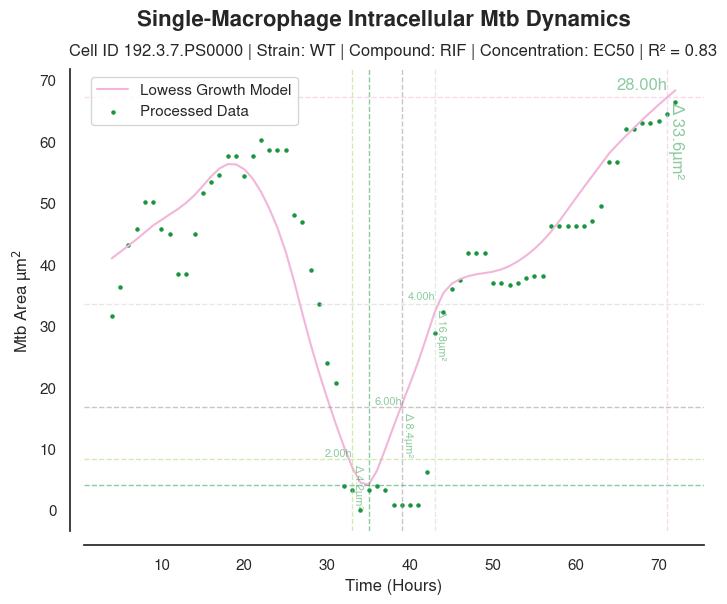

In [40]:
# Get single-cell trajectory in df format
sc_df = df[df['ID'] == ID]
# Drop NaN values specifically from the required columns
sc_df = sc_df.dropna(subset=['Time Model (hours)', 'Mtb Area Model (µm)', 'Mtb Area Processed (µm)'])
# Ensure there is temporal order
sc_df = sc_df.sort_values(by='Time Model (hours)')
# Extract Strain, Compound, and Concentration for the title
strain, compound, concentration = sc_df[['Strain', 'Compound', 'Concentration']].iloc[0].values
# Calculate the R2 value and skip plotting if R2 < 0.7
r2 = round(r2_score(sc_df['Mtb Area Processed (µm)'], sc_df['Mtb Area Model (µm)']), 2)
df.loc[df['ID'] == ID, 'r2'] = r2
if r2 < 0.7:
    print(f'Nee fitting ({r2})')
# Find the temporal order of the minimum and maximum
min_value = max(sc_df['Mtb Area Model (µm)'].round(1).min(), 1.92) # has to be above the minimum threshold
max_value = sc_df['Mtb Area Model (µm)'].round(1).max()
# perform a check on the data
if max_value <= min_value:
    print(f'No population doubling for ID {ID}')
# Find the time indices of the minimum and maximum
min_index = sc_df['Mtb Area Model (µm)'].round(1).idxmin()
max_index = sc_df['Mtb Area Model (µm)'].round(1).idxmax()
# Check if maximum occurs before minimum
if max_index > min_index:
    growth = True
    # Minimum occurs before the maximum (indicating growth)
    # Start from the minimum and double
    N_i = min_value
    N_series = []
    # Generate the doubling series
    while N_i <= max_value:
        N_series.append(N_i)
        N_i *= 2
else:
    growth = False
    # non_doubling_curves.append(ID)
    print(f'No obvious growth for ID {ID}')
# Check if there are no valid doubling points
if len(N_series) < 2:
    print(f'No population doubling for ID {ID}')
    
# Find the indices and corresponding times for each doubling point
# doubling_time_indices = np.clip(np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series), 0, len(sc_df) - 1) # old method
doubling_time_indices = [np.abs(sc_df['Mtb Area Model (µm)'] - value).idxmin() for value in N_series]
doubling_time_points = sc_df['Time Model (hours)'].loc[closest_indices]
doubling_times = doubling_time_points.diff().dropna().values.tolist()
    
# Plot the experimental data and the fitted model
plt.figure(figsize=(8, 6))
plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label='Lowess Growth Model', color=colours[-2])
plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours[0], s=5)

# Annotate doubling times and draw faint lines
for i, (time, population) in enumerate(zip(doubling_time_points, N_series)):
    time = abs(time)
    population = abs(population)
    color_index = i % len(expanded_piyg)  # This ensures the color index wraps around
    # Draw faint vertical lines at doubling time points
    plt.axvline(x=time, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
    plt.axhline(y=population, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
    
    # Place a text label indicating the doubling time
    if i > 0:  # Start labeling from the second point
        previous_time = doubling_time_points.iloc[i-1]
        
        # Midpoint between the two lines
        label_x_pos = time  # Correct the label position
        # Adjust y-position to place the label just above the horizontal line
        label_y_pos = population + (population * 0.01)  # Slightly above the horizontal line

        # Calculate the gap between the lines and scale the font size
        gap = time - previous_time
        scaled_fontsize = max(8, min(12, gap))  # Scale font size within a reasonable range (e.g., 8 to 12)
        
        # Draw the horizontal doubling time label
        plt.text(label_x_pos, label_y_pos, f'{abs(doubling_times[i-1]):.2f}h', 
                 ha='right', va='bottom', alpha=0.5, fontsize=scaled_fontsize, color=expanded_piyg[0])
        
        # Draw vertical arrow showing the change in N_series (doubling amount)
        deltaMtb = population - N_series[i-1]
        
        # Midpoint for the vertical delta annotation
        text_y_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
        text_x_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population

        # Midpoint between the two lines
        label_x_pos = time + 0.1  # Adjust x-position
        # Adjust y-position to place the label just above the horizontal line
        label_y_pos = population - (max_value * 0.01)
        
        # Place the vertical label using plt.text
        plt.text(label_x_pos, label_y_pos, f'Δ {abs(deltaMtb):.1f}µm²',
                 fontsize=scaled_fontsize, color=expanded_piyg[0], ha='left', va='top', rotation=270, alpha=0.5)

# Add labels, legend, and titles
plt.xlabel('Time (Hours)')
plt.ylabel('Mtb Area µm$^{2}$')
plt.legend()
    # Main title
plt.suptitle('Single-Macrophage Intracellular Mtb Dynamics', 
             weight='bold', fontsize=16)
# Subtitle
plt.title(f'Cell ID {ID} | Strain: {strain} | Compound: {compound} | Concentration: {concentration} | R² = {r2}', fontsize=12, pad=10)

sns.despine(offset=10)
plt.grid(False)

In [28]:
closest_indices

array([375128, 375126, 375132, 375136, 375164])

In [38]:
sc_df['Time Model (hours)'].iloc[[375128, 375126, 375132, 375136, 375164]]

IndexError: positional indexers are out-of-bounds

In [24]:
sc_df['Time Model (hours)']#.iloc[closest_indices]

375097     4.0
375098     5.0
375099     6.0
375100     7.0
375101     8.0
          ... 
375161    68.0
375162    69.0
375163    70.0
375164    71.0
375165    72.0
Name: Time Model (hours), Length: 69, dtype: float64

In [18]:
sc_df['Mtb Area Model (µm)'].values

array([41.00719601, 42.02285865, 43.05188927, 44.11986201, 45.23754087,
       46.36889731, 47.2600589 , 48.15904617, 49.04744801, 50.0639159 ,
       51.31843769, 52.80701554, 54.35388269, 55.64537292, 56.33669959,
       56.29473316, 55.49860789, 54.00798969, 51.86278045, 49.15989416,
       45.95393532, 42.04726826, 37.29682689, 32.05596852, 27.02447827,
       22.44646907, 18.20718853, 14.20556306, 10.4396191 ,  7.04400362,
        4.51282899,  4.1744207 ,  6.45487929,  9.9722285 , 13.64289892,
       17.204069  , 20.67600196, 24.27339804, 28.29299005, 32.40186966,
       35.34524744, 36.85245604, 37.62487131, 38.10956485, 38.41582245,
       38.61713726, 38.8418875 , 39.20586059, 39.76474504, 40.52375469,
       41.45277061, 42.54558321, 43.84164672, 45.36044294, 47.08329461,
       48.93497272, 50.81881311, 52.65872781, 54.45022327, 56.25487691,
       58.07232219, 59.52005168, 60.89060808, 62.23249283, 63.53706838,
       64.8001451 , 66.02132842, 67.20180048, 68.34291693])

In [20]:
np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series, side = 'left')

array([ 0,  0, 35, 40, 67])

In [15]:
N_series

[4.2, 8.4, 16.8, 33.6, 67.2]

In [14]:
doubling_time_indices

array([ 0,  0, 35, 40, 67])

In [13]:
doubling_times

[0.0, 35.0, 5.0, 27.0]

In [25]:
differences

375097    26.192804
375098    25.177141
375099    24.148111
375100    23.080138
375101    21.962459
            ...    
375161     3.662932
375162     2.399855
375163     1.178672
375164     0.001800
375165     1.142917
Name: Mtb Area Model (µm), Length: 69, dtype: float64

In [27]:
sc_df

ID  Time (hours)  Mtb Area (µm)  dMtb Area (µm)  \
375097  192.3.7.PS0000           4.0      36.293902       30.706787   
375098  192.3.7.PS0000           5.0      51.759038       30.706787   
375099  192.3.7.PS0000           6.0      45.859044       30.706787   
375100  192.3.7.PS0000           7.0      55.021914       30.706787   
375101  192.3.7.PS0000           8.0      50.239343       30.706787   
...                ...           ...            ...             ...   
375161  192.3.7.PS0000          68.0      63.424935       30.706787   
375162  192.3.7.PS0000          69.0      66.441978       30.706787   
375163  192.3.7.PS0000          70.0      68.118112       30.706787   
375164  192.3.7.PS0000          71.0      64.475313       30.706787   
375165  192.3.7.PS0000          72.0      66.441978       30.706787   

        Mphi Area (µm)  dMphi Area (µm) Infection Status  \
375097     1520.321179      -765.837099             True   
375098     2042.850571      -765.837099             True   
375099     1922.414709      -765.837099             True   
375100     1878.030663      -765.837099             True   
375101     1723.245215      -765.837099             True   
...                ...              ...              ...   
375161     1116.819696      -765.837099             True   
375162     1038.465988      -765.837099             True   
375163      995.042926      -765.837099             True   
375164      976.292566      -765.837099             True   
375165     1027.157666      -765.837099             True   

        Initial Infection Status  Final Infection Status            x  ...  \
375097                      True                    True  1015.168274  ...   
375098                      True                    True  1017.233337  ...   
375099                      True                    True  1019.625366  ...   
375100                      True                    True  1019.817200  ...   
375101                      True                    True  1018.286438  ...   
...                          ...                     ...          ...  ...   
375161                      True                    True  1038.407593  ...   
375162                      True                    True  1038.819824  ...   
375163                      True                    True  1045.136963  ...   
375164                      True                    True  1044.146240  ...   
375165                      True                    True  1049.712402  ...   

        Edge Status  Uptake  dMtb Area between frames (µm)  \
375097        False   False                      -6.838629   
375098        False   False                      15.465136   
375099        False   False                      -5.899994   
375100        False   False                       9.162869   
375101        False   False                      -4.782571   
...             ...     ...                            ...   
375161        False   False                      10.749610   
375162        False   False                       3.017042   
375163        False   False                       1.676135   
375164        False   False                      -3.642799   
375165        False   False                       1.966665   

        Mtb Area Processed (µm)  Time Model (hours)  Mtb Area Model (µm)  \
375097                31.645422                 4.0            41.007196   
375098                36.293902                 5.0            42.022859   
375099                43.132532                 6.0            43.051889   
375100                45.859044                 7.0            44.119862   
375101                50.239343                 8.0            45.237541   
...                         ...                 ...                  ...   
375161                63.112057                68.0            63.537068   
375162                63.112057                69.0            64.800145   
375163                63.424935                70.0            66.021328   
3751

In [26]:
closest_indices

array([375128, 375126, 375132, 375136, 375164])

In [21]:
# Find closest indices manually
closest_indices = []
for value in N_series:
    # Calculate the absolute differences
    differences = np.abs(sc_df['Mtb Area Model (µm)'] - value)
    
    # Find the index of the minimum difference
    closest_index = differences.idxmin()
    
    # Append to the list
    closest_indices.append(closest_index)

# Convert to an array
closest_indices= np.array(closest_indices)
closest_indices

array([375128, 375126, 375132, 375136, 375164])

In [39]:
[np.abs(sc_df['Mtb Area Model (µm)'] - value).idxmin() for value in N_series]

[375128, 375126, 375132, 375136, 375164]

In [22]:
df['Time (hours)'][closest_indices]

375128    35.0
375126    33.0
375132    39.0
375136    43.0
375164    71.0
Name: Time (hours), dtype: float64

329.6.4.PS0000


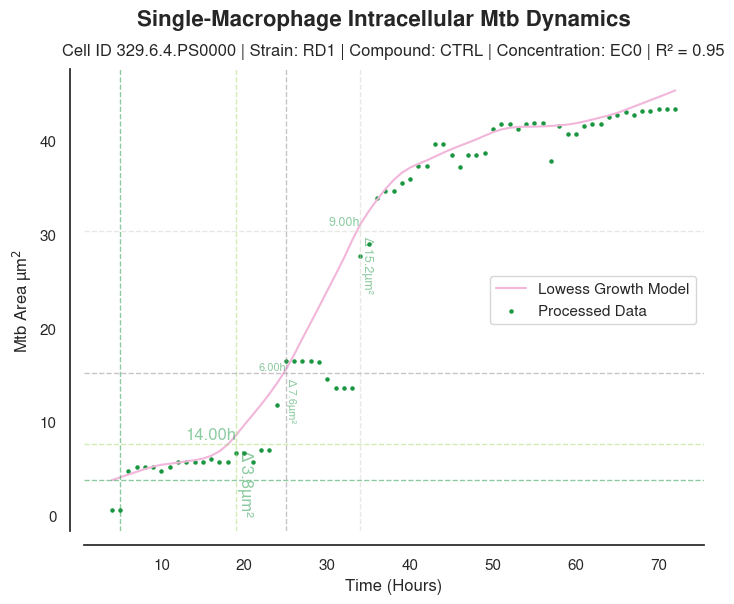

329.6.4.PS0000


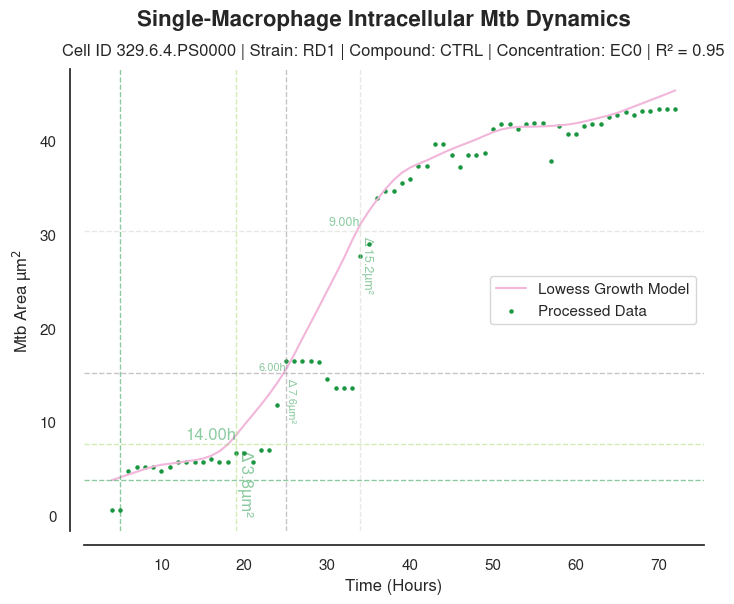

706.3.4.PS0000


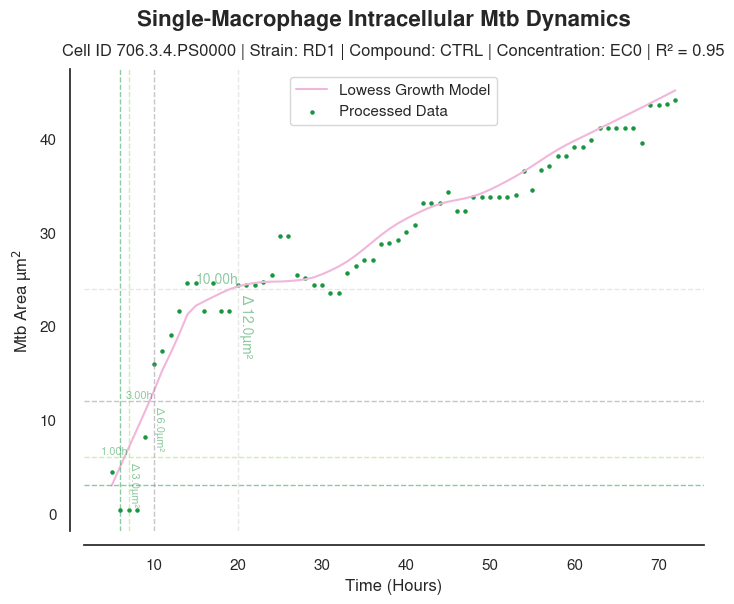

706.3.4.PS0000


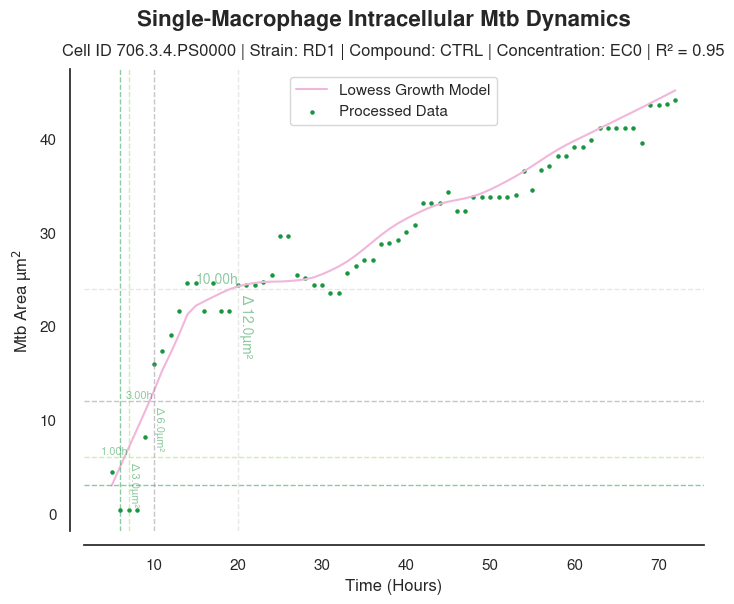

In [96]:
for i, ID in enumerate(subset_df[subset_df['Doubling Times'] < 10].ID.values):

    print(ID)    
    # if i <10:
    #     continue
    plot(ID, df, save = False, napari = False)

In [161]:
df.loc[df['ID'] == ID, 'mtb_origin'] = 'Transfer'
df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')


In [138]:
df.loc[df['ID'] == ID, 'mtb_origin'] = None
df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
df.loc[df['ID'] == ID, 'Doubling Times'] = None
# df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df_v2.pkl')#'/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')
df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')


In [144]:
df.loc[df['ID'] == ID, 'mtb_origin'] = None
df.loc[df['ID'] == ID, 'Doubling Amounts'] = df.loc[df['ID'] == ID].apply(lambda x: [10.2], axis=1)
df.loc[df['ID'] == ID, 'Doubling Times'] = df.loc[df['ID'] == ID].apply(lambda x: [47], axis=1)
df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')


# Plot doubling times 

In [254]:
def filter_df(df, r2=0.7, compounds=None, exclude_compounds=False, 
              strains=None, exclude_strains=False, concentration=None, 
              exclude_edge_status=True, average_doubling_times=False):
    """
    Prepares a filtered dataframe by filtering on r2, edge status, strain, compound, concentration,
    and processes the 'Doubling Times' column either by exploding or averaging per ID.
    
    Parameters:
    df (pd.DataFrame): The input dataframe to filter.
    r2_threshold (float): The minimum r2 value to filter by.
    compounds (list): List of compounds to filter on (or exclude if exclude_compounds is True).
    exclude_compounds (bool): If True, exclude the specified compounds.
    strains (list): List of strains to filter on (or exclude if exclude_strains is True).
    exclude_strains (bool): If True, exclude the specified strains.
    concentration (float or None): Filter on specific concentration if provided.
    exclude_edge_status (bool): If True, do not filter on edge status.
    average_doubling_times (bool): If True, averages doubling times for each ID instead of exploding them.
    
    Returns:
    pd.DataFrame: The filtered and processed dataframe.
    """
    # Initial filter on r2
    subset_df = df[df['r2'] >= r2].drop_duplicates(subset=['ID'])
    # Filter edge status if not excluded
    if exclude_edge_status:
        subset_df = subset_df[subset_df['Edge Status'] == False]

    # Filter or exclude compounds
    if compounds is not None:
        if exclude_compounds:
            subset_df = subset_df[~subset_df['Compound'].isin(compounds)]
        else:
            subset_df = subset_df[subset_df['Compound'].isin(compounds)]

    # Filter or exclude strains
    if strains is not None:
        if exclude_strains:
            subset_df = subset_df[~subset_df['Strain'].isin(strains)]
        else:
            subset_df = subset_df[subset_df['Strain'].isin(strains)]

    # Filter concentration if provided
    if concentration is not None:
        subset_df = subset_df[subset_df['Concentration'] == concentration]

    # Process 'Doubling Times'
    if average_doubling_times:
        subset_df['Doubling Times'] = subset_df['Doubling Times'].apply(lambda x: sum(x) / len(x) if isinstance(x, list) else x)
    else:
        subset_df = subset_df.explode('Doubling Times')

    # Convert 'Doubling Times' to numeric and filter for valid, positive values
    subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')
    subset_df = subset_df[subset_df['Doubling Times'].notna() & (subset_df['Doubling Times'] > 0)]
    
    return subset_df


<Axes: xlabel='Doubling Times', ylabel='Count'>

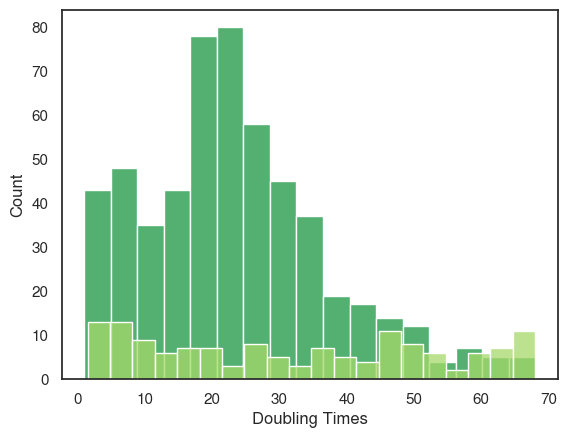

In [10]:
subset_df = df[(df['r2']>=0.7) & 
               # (df['r2']<1) & 
               # (df['Doubling Times']>0) & 
               (df['Edge Status']==False) &
                (df['mtb_origin'].isna()) & 
               (df['Strain'] == 'WT') &
                (df['Concentration'] == 'EC0') 
                ].drop_duplicates(subset=['ID'])

# Explode the 'Doubling Times' column so that each value in the list becomes a separate row
subset_df = subset_df.explode('Doubling Times')

# Convert 'Doubling Times' to numeric in case there are any non-numeric values
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')

# Filter out None or NaN values in 'Doubling Times'
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]

sns.histplot(subset_df['Doubling Times'])

subset_df = df[(df['r2']>=0.7) & 
               # (df['r2']<1) & 
               # (df['Doubling Times']>0) & 
               (df['Edge Status']==False) &
                (df['mtb_origin'].isna()) & 
               (df['Strain'] == 'RD1') &
                (df['Concentration'] == 'EC0') 
                ].drop_duplicates(subset=['ID'])

# Explode the 'Doubling Times' column so that each value in the list becomes a separate row
subset_df = subset_df.explode('Doubling Times')

# Convert 'Doubling Times' to numeric in case there are any non-numeric values
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')

# Filter out None or NaN values in 'Doubling Times'
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]

sns.histplot(subset_df['Doubling Times'], bins = 20)

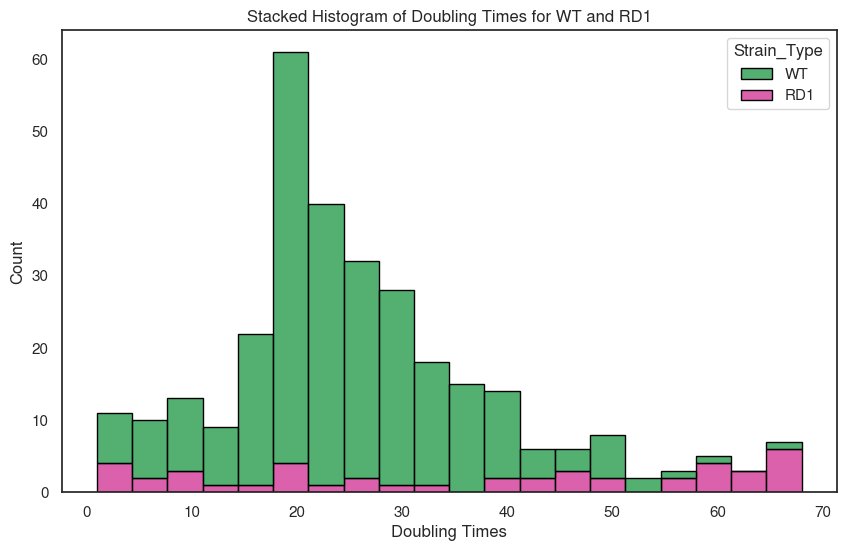

In [11]:
# Define colors for WT and RD1 from the 'expanded_piyg' palette
colors = [expanded_piyg[0], expanded_piyg[-1]]
r2_threshold = 0.95
# Combine the two subsets into one DataFrame with an additional 'Strain' column
subset_wt = df[(df['r2'] >= r2_threshold) & 
               (df['Edge Status'] == False) &
               (df['mtb_origin'].isna()) & 
               (df['Strain'] == 'WT') &
               (df['Concentration'] == 'EC0')].drop_duplicates(subset=['ID'])

subset_rd1 = df[(df['r2'] >= r2_threshold) & 
                (df['Edge Status'] == False) &
                (df['mtb_origin'].isna()) & 
                (df['Strain'] == 'RD1') &
                (df['Concentration'] == 'EC0')].drop_duplicates(subset=['ID'])

# Add a 'Strain' column to each subset
subset_wt['Strain_Type'] = 'WT'
subset_rd1['Strain_Type'] = 'RD1'

# Combine the subsets
combined_df = pd.concat([subset_wt, subset_rd1])

# Explode the 'Doubling Times' column
combined_df = combined_df.explode('Doubling Times')

# Convert 'Doubling Times' to numeric and filter out NaN and non-positive values
combined_df['Doubling Times'] = pd.to_numeric(combined_df['Doubling Times'], errors='coerce')
combined_df = combined_df[combined_df['Doubling Times'].notna() & (combined_df['Doubling Times'] > 0)]

# Plot the stacked histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x='Doubling Times', hue='Strain_Type', bins=20,
             palette=colors, multiple='stack', edgecolor='black')

# Add labels and title
plt.xlabel('Doubling Times')
plt.ylabel('Count')
plt.title('Stacked Histogram of Doubling Times for WT and RD1')

# Show plot
plt.show()


/tmp/ipykernel_2154516/2987388616.py:21: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.boxplot(x="Doubling Times", y="Strain",


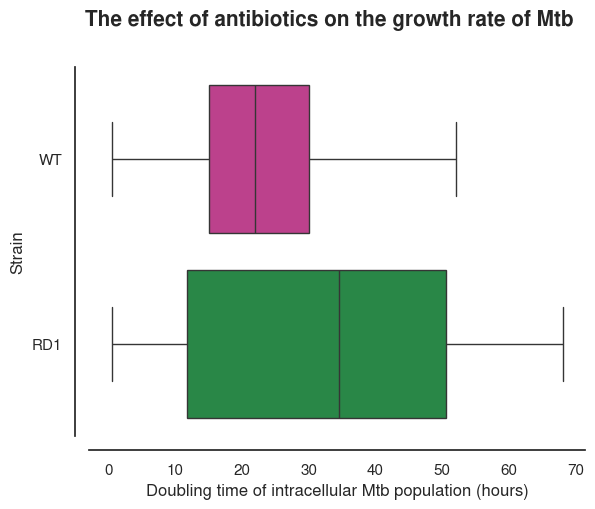

In [124]:
hue_order = ['EC50', 'EC0', 'EC99']
subset_df = df[(df['r2']>=0.59) & 
               # (df['r2']<1) & 
               # (df['Doubling Times']>0) & 
               (df['Edge Status']==False) &
                # (df['mtb_origin'].isna()) & 
               (df['Strain'] != 'UNI') & 
                (df['Compound'] == 'CTRL') 
                ].drop_duplicates(subset=['ID'])

# Explode the 'Doubling Times' column so that each value in the list becomes a separate row
subset_df = subset_df.explode('Doubling Times')

# Convert 'Doubling Times' to numeric in case there are any non-numeric values
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')

# Filter out None or NaN values in 'Doubling Times'
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]

g = sns.boxplot(x="Doubling Times", y="Strain",
            # hue="Strain", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=subset_df, 
            hue_order=hue_order, fliersize = 0
            # scale = 'linear'
              )  
sns.despine(offset = 10)
plt.xlabel("Doubling time of intracellular Mtb population (hours)")
plt.gcf().suptitle('The effect of antibiotics on the growth rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                  y = 1.0)
sns.despine(offset=10)
# plt.legend(loc = 'lower right', frameon = False, title = 'Concentration')
# plt.xlim(0, 40)
# plt.savefig(os.path.join(output_dir, 'ATB_effect_dt_gt0_violin.png'), bbox_inches='tight', dpi=314)


# KDE representation

/tmp/ipykernel_2154516/1925089703.py:19: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.kdeplot(data=subset_df, x="Doubling Times", hue="Strain",


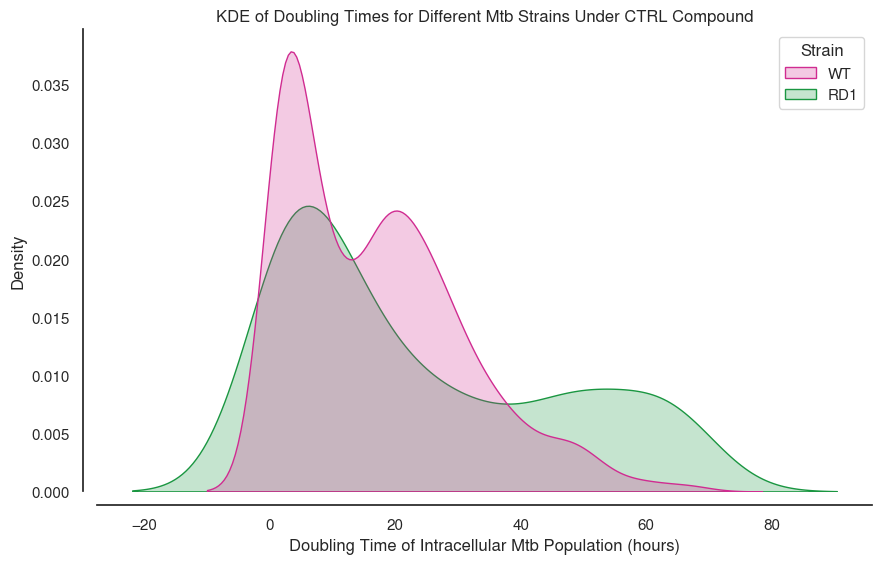

In [205]:
# Prepare the subset DataFrame as before
subset_df = df[(df['r2'] >= 0.8) & 
               (df['Edge Status'] == False) &
               (df['Strain'] != 'UNI') & 
               (df['Compound'] == 'CTRL')].drop_duplicates(subset=['ID'])

# Explode the 'Doubling Times' column so that each value in the list becomes a separate row
subset_df = subset_df.explode('Doubling Times')

# Convert 'Doubling Times' to numeric in case there are any non-numeric values
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')

# Filter out None or NaN values in 'Doubling Times'
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]

# Plot the KDE for each strain
plt.figure(figsize=(10, 6))
sns.kdeplot(data=subset_df, x="Doubling Times", hue="Strain",
            common_norm=False,  # Ensure each KDE is normalized independently
            fill=True,  # Fill under the KDE curves
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]])

# Add labels and title
plt.xlabel("Doubling Time of Intracellular Mtb Population (hours)")
plt.ylabel("Density")
plt.title('KDE of Doubling Times for Different Mtb Strains Under CTRL Compound')

# Customize the plot
sns.despine(offset=10)
plt.show()


# strip plot

N=1093


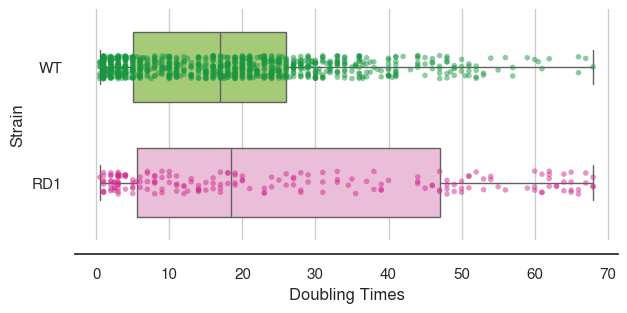

In [12]:
# Prepare the subset DataFrame as before
subset_df = df[(df['r2'] >= 0.8) 
             & (df['Edge Status'] == False) 
             & (df['Strain'] != 'UNI') 
             & (df['Compound'] == 'CTRL')
             & (df['mtb_origin'] != 'Junk')
               ].drop_duplicates(subset=['ID'])
subset_df = subset_df.explode('Doubling Times')
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]
print(f'N={len(subset_df)}')
# Initialize the figure (without logarithmic scale as doubling times are likely linear)
f, ax = plt.subplots(figsize=(7, 3))

# Create the boxplot for the doubling times by strain
sns.boxplot(
    data=subset_df, x="Doubling Times", y="Strain", hue="Strain", 
    whis=[0, 100], width=.6, palette=[expanded_piyg[1], expanded_piyg[-2]]
)

# Add a stripplot to show each observation
sns.stripplot(
    data=subset_df, x="Doubling Times", y="Strain", size=4, hue="Strain", palette=[expanded_piyg[0], expanded_piyg[-1]],
    alpha = 0.5
)

# Tweak the visual presentation
ax.xaxis.grid(True)
# ax.set(ylabel="")  # Remove y-axis label for a cleaner look
sns.despine(offset = 10, left=True)

# Save the figure
# plt.savefig(os.path.join(output_dir, 'boxplot_stripplot_doubling_times.pdf'), dpi=314)
plt.show()

N=612


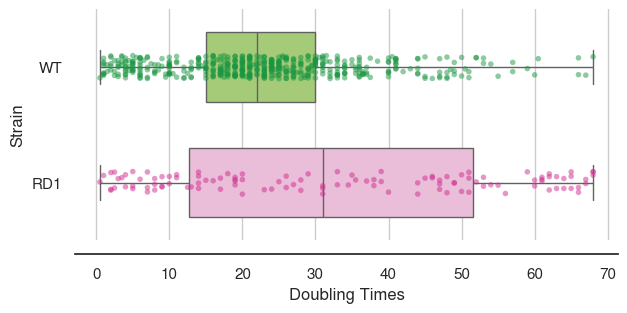

In [299]:
# Prepare the subset DataFrame as before
subset_df = df[(df['r2'] >= 0.8) 
             & (df['Edge Status'] == False) 
             & (df['Strain'] != 'UNI') 
             & (df['Compound'] == 'CTRL')
             & (df['mtb_origin'].isna()) # are we really doing this right now? or after figure 3? 
               ].drop_duplicates(subset=['ID'])
subset_df = subset_df.explode('Doubling Times')
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]
print(f'N={len(subset_df)}')
# Initialize the figure (without logarithmic scale as doubling times are likely linear)
f, ax = plt.subplots(figsize=(7, 3))

# Create the boxplot for the doubling times by strain
sns.boxplot(
    data=subset_df, x="Doubling Times", y="Strain", hue="Strain", 
    whis=[0, 100], width=.6, palette=[expanded_piyg[1], expanded_piyg[-2]]
)

# Add a stripplot to show each observation
sns.stripplot(
    data=subset_df, x="Doubling Times", y="Strain", size=4, hue="Strain", palette=[expanded_piyg[0], expanded_piyg[-1]],
    alpha = 0.5
)

# Tweak the visual presentation
ax.xaxis.grid(True)
# ax.set(ylabel="")  # Remove y-axis label for a cleaner look
sns.despine(offset = 10, left=True)

# Save the figure
# plt.savefig(os.path.join(output_dir, 'boxplot_stripplot_doubling_times.pdf'), dpi=314)
plt.show()

N=633


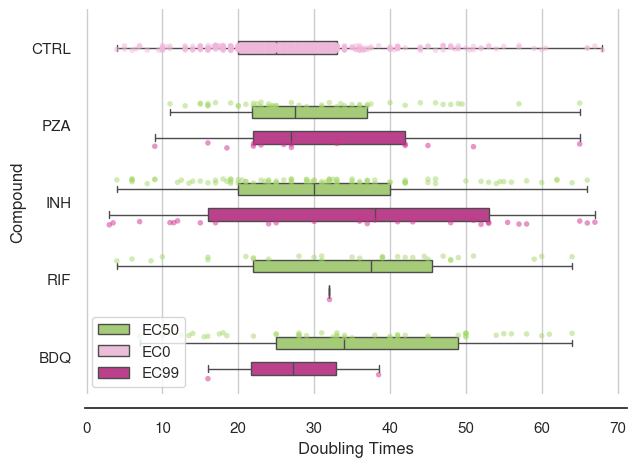

In [6]:
# Prepare the subset DataFrame as before
subset_df = df[(df['r2'] >= 0.8) 
             & (df['Edge Status'] == False) 
             & (df['Strain'] == 'WT') 
             # & (df['Compound'] == 'CTRL')
             & (df['mtb_origin'].isna()) # are we really doing this right now? or after figure 3? 
               ].drop_duplicates(subset=['ID'])
# Exclude CTRL rows without EC50 or EC99 values from causing alignment issues
# subset_df = subset_df[(subset_df['Compound'] != 'CTRL') | (subset_df['Concentration'] == 'EC0')]
subset_df = subset_df.explode('Doubling Times')
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]
print(f'N={len(subset_df)}')

# Initialize the figure
f, ax = plt.subplots(figsize=(7, 5))

# Define hue_order for consistency
hue_order = ['EC50', 'EC0', 'EC99']

# Create the boxplot
sns.boxplot(
    data=subset_df, x="Doubling Times", y="Compound", hue="Concentration", 
    whis=[0, 100], width=.5, palette=[expanded_piyg[1], expanded_piyg[4], expanded_piyg[5]], hue_order=hue_order
)

# Add the stripplot
sns.stripplot(
    data=subset_df, x="Doubling Times", y="Compound", hue="Concentration", size=4, 
    palette=[expanded_piyg[1], expanded_piyg[4], expanded_piyg[5]], hue_order=hue_order, dodge=True, alpha=0.5
)

# Remove the double legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], labels[0:3])

# Tweak visual presentation
ax.xaxis.grid(True)
sns.despine(offset=10, left=True)

# Show the plot
plt.show()


N=142


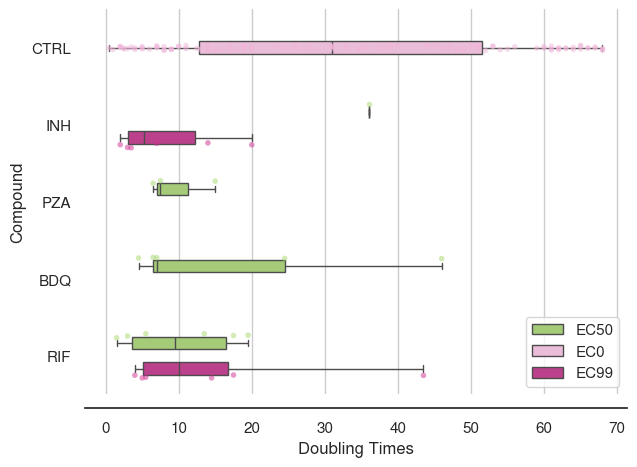

In [310]:
# Prepare the subset DataFrame as before
subset_df = df[(df['r2'] >= 0.8) 
             & (df['Edge Status'] == False) 
             & (df['Strain'] == 'RD1') 
             # & (df['Compound'] == 'CTRL')
             & (df['mtb_origin'].isna()) # are we really doing this right now? or after figure 3? 
               ].drop_duplicates(subset=['ID'])
# Exclude CTRL rows without EC50 or EC99 values from causing alignment issues
# subset_df = subset_df[(subset_df['Compound'] != 'CTRL') | (subset_df['Concentration'] == 'EC0')]
subset_df = subset_df.explode('Doubling Times')
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]
print(f'N={len(subset_df)}')

# Initialize the figure
f, ax = plt.subplots(figsize=(7, 5))

# Define hue_order for consistency
hue_order = ['EC50', 'EC0', 'EC99']

# Create the boxplot
sns.boxplot(
    data=subset_df, x="Doubling Times", y="Compound", hue="Concentration", 
    whis=[0, 100], width=.5, palette=[expanded_piyg[1], expanded_piyg[4], expanded_piyg[5]], hue_order=hue_order
)

# Add the stripplot
sns.stripplot(
    data=subset_df, x="Doubling Times", y="Compound", hue="Concentration", size=4, 
    palette=[expanded_piyg[1], expanded_piyg[4], expanded_piyg[5]], hue_order=hue_order, dodge=True, alpha=0.5
)

# Remove the double legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], labels[0:3])

# Tweak visual presentation
ax.xaxis.grid(True)
sns.despine(offset=10, left=True)

# Show the plot
plt.show()


# Which of these doubling times are from uptake? 

N=2095


/tmp/ipykernel_2154516/3080210839.py:43: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(


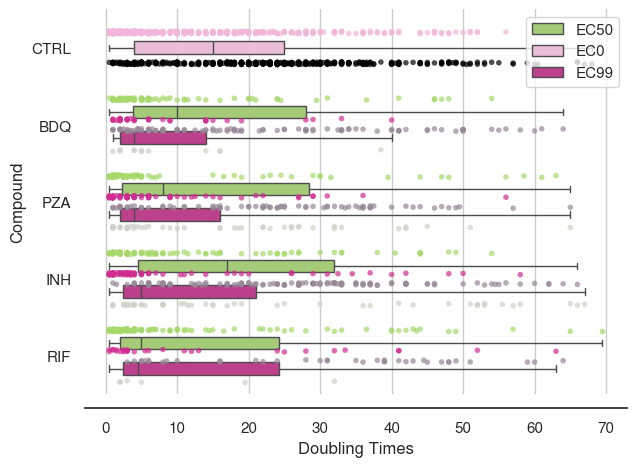

In [317]:
# Prepare the subset DataFrame as before
subset_df = df[(df['r2'] >= 0.8) 
             & (df['Edge Status'] == False) 
             & (df['Strain'] == 'WT') 
             # & (df['Compound'] == 'CTRL')
             # & (df['mtb_origin'].isna()) # are we really doing this right now? or after figure 3? 
               ].drop_duplicates(subset=['ID'])
# Exclude CTRL rows without EC50 or EC99 values from causing alignment issues
# subset_df = subset_df[(subset_df['Compound'] != 'CTRL') | (subset_df['Concentration'] == 'EC0')]
subset_df = subset_df.explode('Doubling Times')
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]
# Add a new column to check the unmet condition (if mtb_origin is NaN)
subset_df['uptake/transfer'] = ~subset_df['mtb_origin'].isna()
print(f'N={len(subset_df)}')

# Initialize the figure
f, ax = plt.subplots(figsize=(7, 5))

# Define hue_order for consistency
hue_order = ['EC50', 'EC0', 'EC99']

# Create a combined column for hue that combines 'Concentration' and 'uptake/transfer'
subset_df['combined_hue'] = subset_df['Concentration'] + "_" + subset_df['uptake/transfer'].astype(str)

# Define the new palette for all possible combinations
combined_palette = {
    'EC50_True': expanded_piyg[1], 'EC0_True': expanded_piyg[4], 'EC99_True': expanded_piyg[5],
    'EC50_False': expanded_piyg[2], 'EC0_False': 'black', 'EC99_False': expanded_piyg[3]
}

# Define the combined hue order
combined_hue_order = ['EC50_True', 'EC0_True', 'EC99_True', 'EC50_False', 'EC0_False', 'EC99_False']

# Create the boxplot
sns.boxplot(
    data=subset_df, x="Doubling Times", y="Compound", hue="Concentration", 
    whis=[0, 100], width=.5, palette=[expanded_piyg[1], expanded_piyg[4], expanded_piyg[5]], hue_order=hue_order
)

# Add the stripplot using the combined hue
sns.stripplot(
    data=subset_df, x="Doubling Times", y="Compound", hue="Concentration", size=4, 
    palette=[expanded_piyg[1], expanded_piyg[4], expanded_piyg[5]], hue_order=combined_hue_order, dodge=True, alpha=0.7
)

# Add the stripplot using the combined hue
sns.stripplot(
    data=subset_df, x="Doubling Times", y="Compound", hue="combined_hue", size=4, 
    palette=combined_palette, hue_order=combined_hue_order, dodge=True, alpha=0.7
)

# Remove the double legend and customize
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], labels[0:3])

# Tweak visual presentation
ax.xaxis.grid(True)
sns.despine(offset=10, left=True)

# Show the plot
plt.show()

# Pie charts

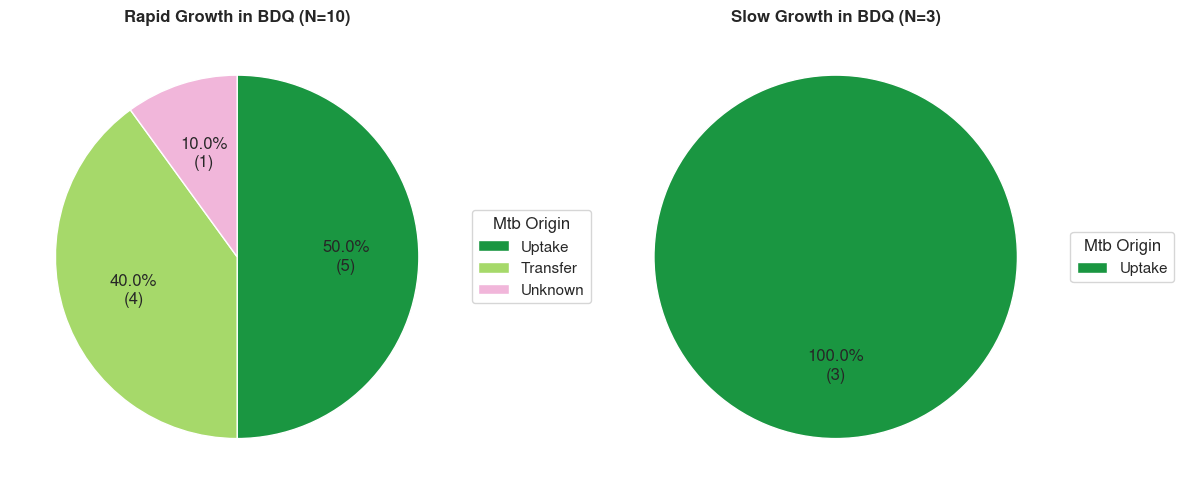

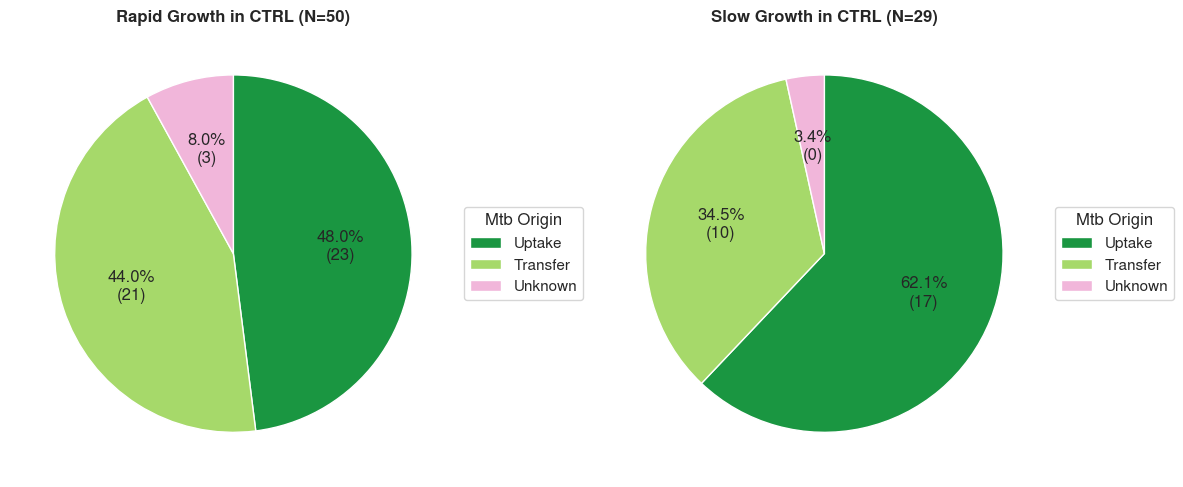

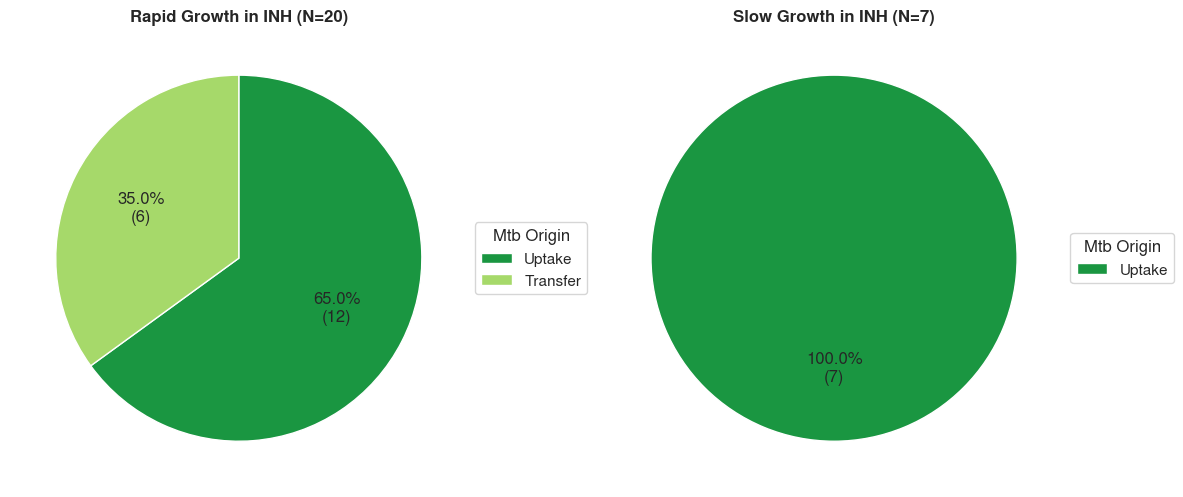

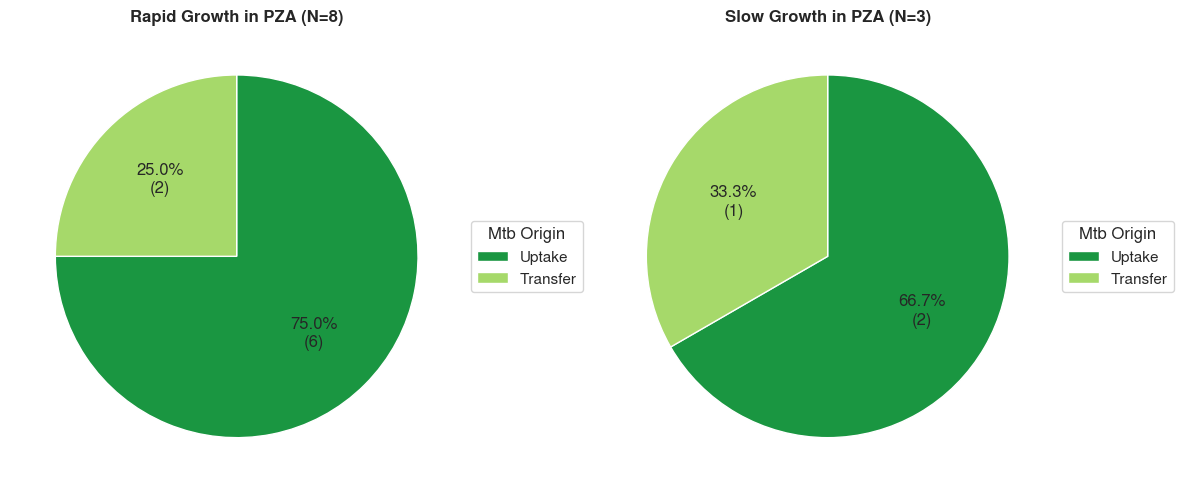

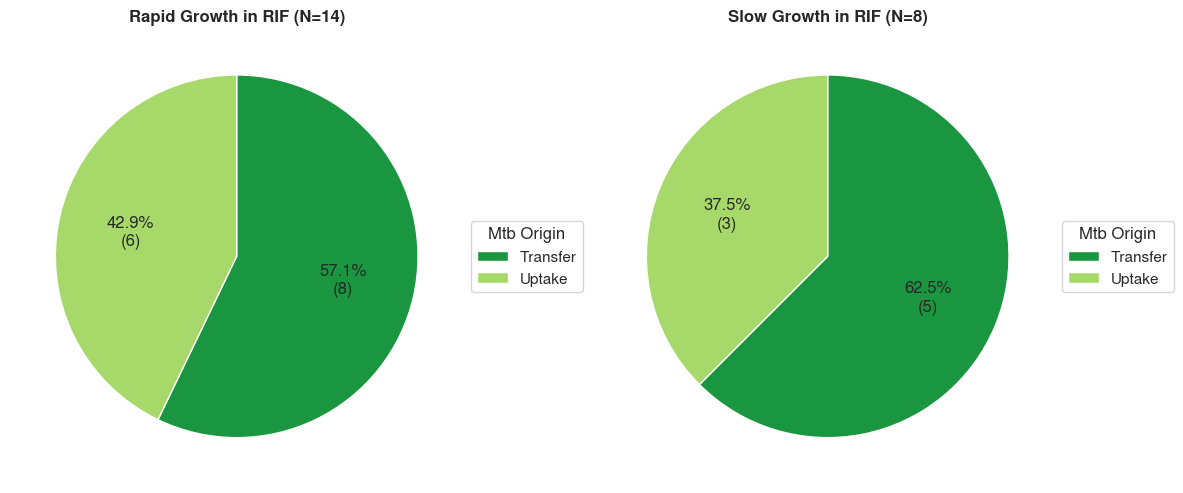

In [177]:
# Function to add counts to pie chart
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return f"{pct:.1f}%\n({absolute:d})"

# Colors from expanded_piyg
colors = ['#1a9641', '#a6d96a', '#f1b6da', '#d02c91']

# Group by 'Compound' and 'Concentration'
grouped = df.drop_duplicates('ID').groupby(['Compound'])

# Iterate over each group
for compound, group in grouped:
    # Filter out 'Junk'
    filtered_group = group[(group['mtb_origin'] != 'Junk') & ~(group['mtb_origin'].isna()) & (group['Strain'] == 'RD1')]
    filtered_group = filtered_group.explode('Doubling Times')
    # if compound == 'CTRL':
    #     break
    # Separate into rapid growth and other growth
    rapid_growth = filtered_group[filtered_group['Doubling Times'] <= 18].drop_duplicates('ID')
    other_growth = filtered_group[filtered_group['Doubling Times'] > 18].drop_duplicates('ID')

    # Count the occurrences of each unique value in the 'mtb_origin' column for both groups
    rapid_growth_counts = rapid_growth['mtb_origin'].value_counts()
    other_growth_counts = other_growth['mtb_origin'].value_counts()


    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the rapid growth pie chart
    wedges_rapid, texts_rapid, autotexts_rapid = axes[0].pie(
        rapid_growth_counts,
        autopct=lambda pct: func(pct, rapid_growth_counts),
        startangle=90,
        counterclock=False,
        colors=colors
    )
    axes[0].set_title(f'Rapid Growth in {compound} (N={rapid_growth_counts.sum()})', fontweight='bold')
    axes[0].set_ylabel('')  # Hide the y-label

    # Plot the other growth pie chart
    wedges_other, texts_other, autotexts_other = axes[1].pie(
        other_growth_counts,
        autopct=lambda pct: func(pct, other_growth_counts),
        startangle=90,
        counterclock=False,
        colors=colors
    )
    axes[1].set_title(f'Slow Growth in {compound} (N={other_growth_counts.sum()})', fontweight='bold')
    axes[1].set_ylabel('')  # Hide the y-label

    # Add legends for both subplots
    labels = rapid_growth_counts.index.tolist()
    axes[0].legend(wedges_rapid, labels, title="Mtb Origin", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    axes[1].legend(wedges_other, labels, title="Mtb Origin", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # Adjust layout
    plt.tight_layout()

    # Display the pie charts
    plt.show()

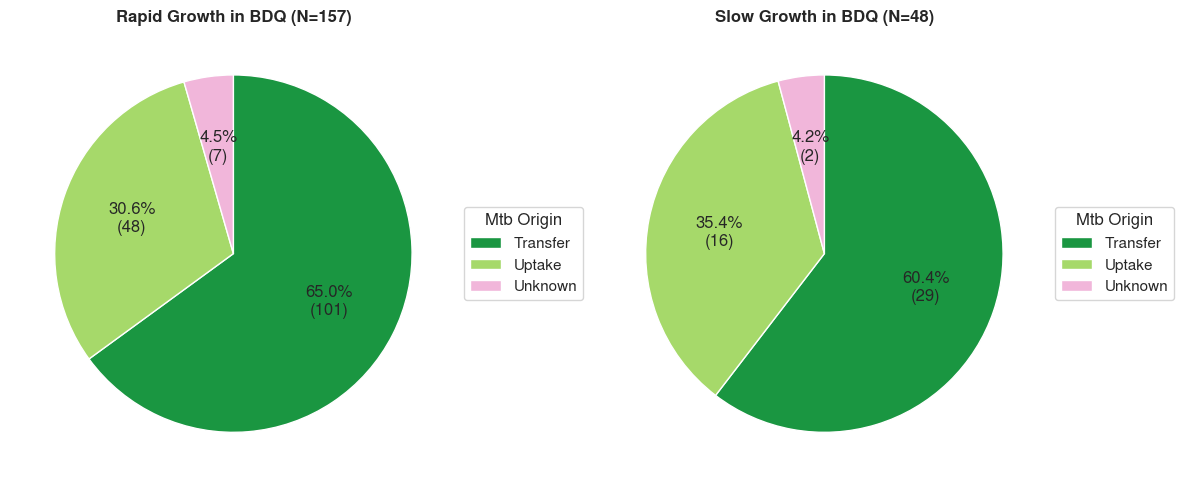

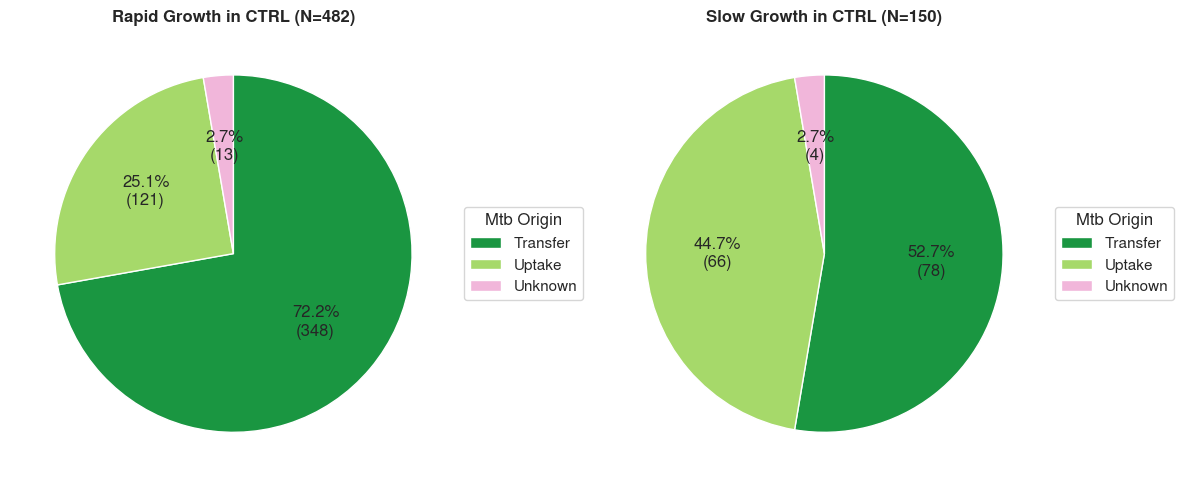

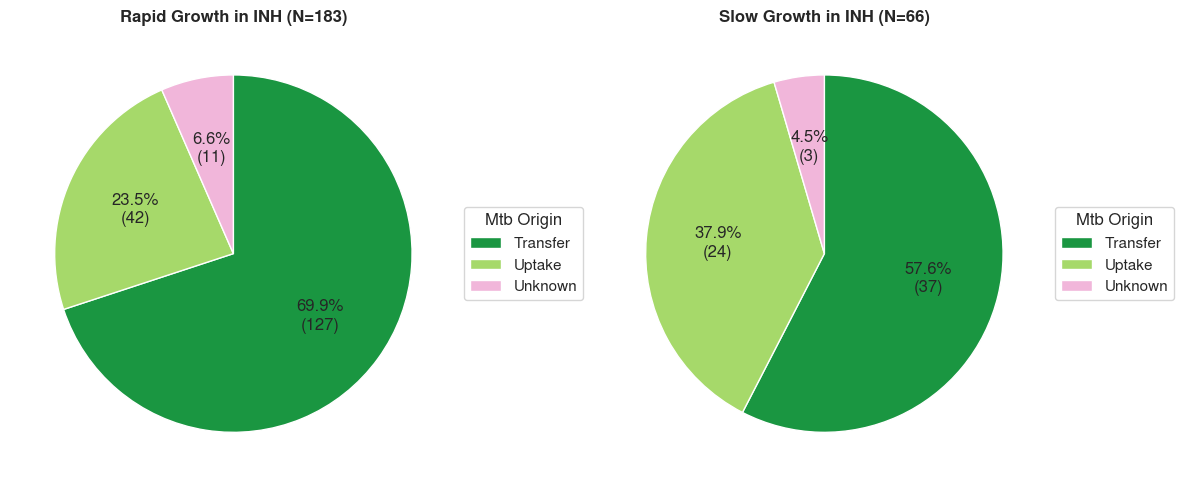

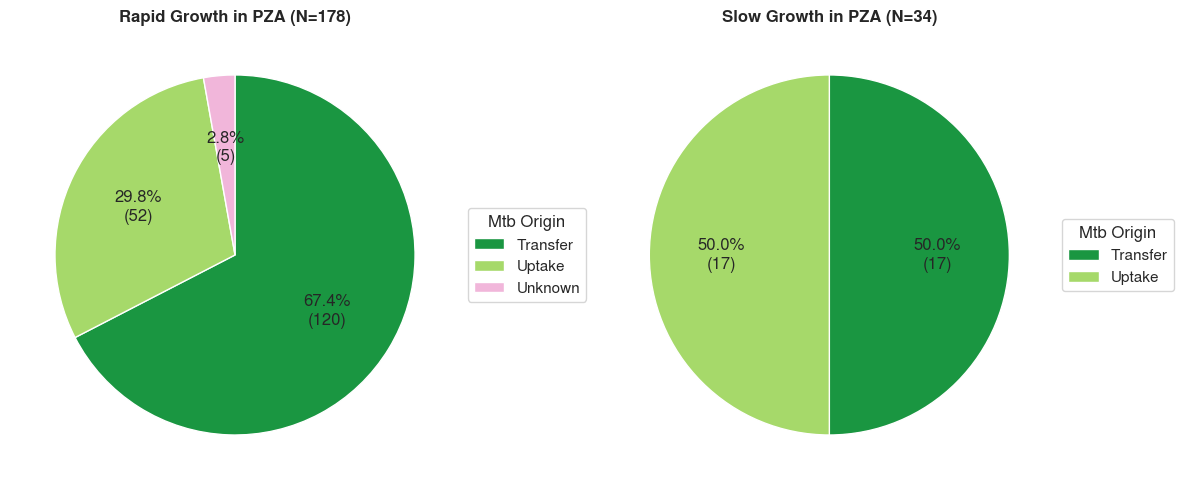

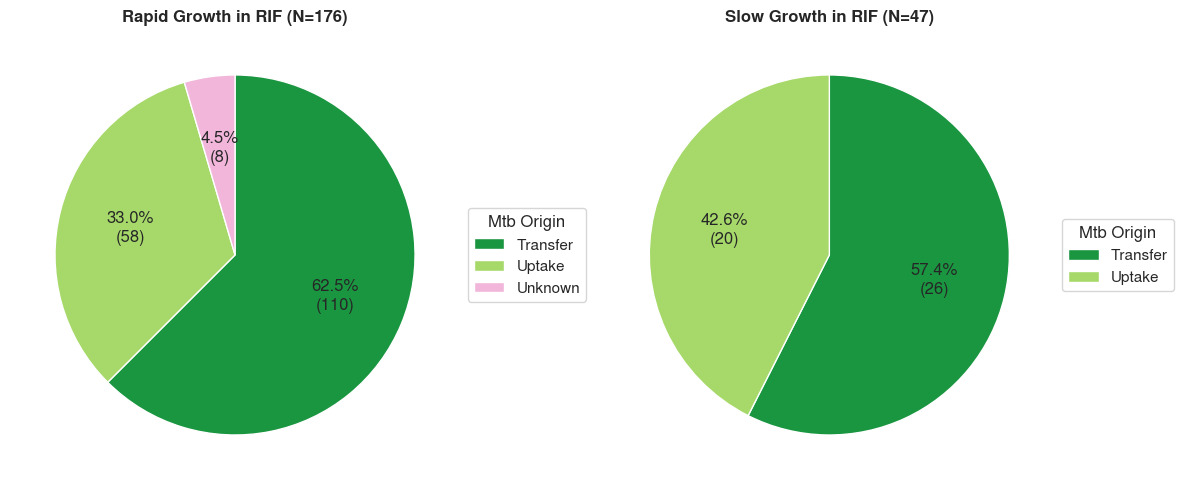

In [178]:
# Function to add counts to pie chart
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return f"{pct:.1f}%\n({absolute:d})"

threshold_hr = 15

# Colors from expanded_piyg
colors = ['#1a9641', '#a6d96a', '#f1b6da', '#d02c91']

# Group by 'Compound' and 'Concentration'
grouped = df.drop_duplicates('ID').groupby(['Compound'])

# Iterate over each group
for compound, group in grouped:
    # Filter out 'Junk'
    filtered_group = group[(group['mtb_origin'] != 'Junk') & ~(group['mtb_origin'].isna()) & (group['Strain'] != 'RD1')]
    filtered_group = filtered_group.explode('Doubling Times')

    # Separate into rapid growth and other growth
    rapid_growth = filtered_group[filtered_group['Doubling Times'] <= threshold_hr]
    other_growth = filtered_group[filtered_group['Doubling Times'] > threshold_hr]

    # Count the occurrences of each unique value in the 'mtb_origin' column for both groups
    rapid_growth_counts = rapid_growth['mtb_origin'].value_counts()
    other_growth_counts = other_growth['mtb_origin'].value_counts()


    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the rapid growth pie chart
    wedges_rapid, texts_rapid, autotexts_rapid = axes[0].pie(
        rapid_growth_counts,
        autopct=lambda pct: func(pct, rapid_growth_counts),
        startangle=90,
        counterclock=False,
        colors=colors
    )
    axes[0].set_title(f'Rapid Growth in {compound} (N={rapid_growth_counts.sum()})', fontweight='bold')
    axes[0].set_ylabel('')  # Hide the y-label

    # Plot the other growth pie chart
    wedges_other, texts_other, autotexts_other = axes[1].pie(
        other_growth_counts,
        autopct=lambda pct: func(pct, other_growth_counts),
        startangle=90,
        counterclock=False,
        colors=colors
    )
    axes[1].set_title(f'Slow Growth in {compound} (N={other_growth_counts.sum()})', fontweight='bold')
    axes[1].set_ylabel('')  # Hide the y-label

    # Add legends for both subplots
    labels = rapid_growth_counts.index.tolist()
    axes[0].legend(wedges_rapid, labels, title="Mtb Origin", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    axes[1].legend(wedges_other, labels, title="Mtb Origin", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # Adjust layout
    plt.tight_layout()

    # Display the pie charts
    plt.show()

# Checking lowest doubling times

In [13]:
# Prepare the subset DataFrame as before
subset_df = df[(df['r2'] >= 0.8) 
             & (df['Edge Status'] == False) 
             & (df['Strain'] != 'UNI') 
             # & (df['Compound'] == 'CTRL')
             & (df['mtb_origin'].isna()) # are we really doing this right now? or after figure 3? 
               ].drop_duplicates(subset=['ID'])
subset_df = subset_df.explode('Doubling Times')
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]
print(f'N={len(subset_df)}')

N=735


In [7]:
# Prepare the subset DataFrame as before
subset_df = df[(df['r2'] >= 0.7) 
             & (df['r2'] < 0.8) 
             & (df['Edge Status'] == False) 
             & (df['Strain'] != 'UNI') 
             # & (df['Compound'] == 'CTRL')
             & (df['mtb_origin'].isna()) # are we really doing this right now? or after figure 3? 
               ].drop_duplicates(subset=['ID'])
subset_df = subset_df.explode('Doubling Times')
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]
print(f'N={len(subset_df)}')

N=254


In [8]:
subset_df[subset_df['Compound'] == 'RIF']

ID  Time (hours)  Mtb Area (µm)  dMtb Area (µm)  \
76192    1169.6.8.ND0003          11.0      26.348837      -12.023473   
347268    185.3.8.ND0002           0.5       4.737874       12.626881   
504233   2294.6.7.ND0003          32.0       4.559086       55.401838   
504233   2294.6.7.ND0003          32.0       4.559086       55.401838   
504233   2294.6.7.ND0003          32.0       4.559086       55.401838   
527971   2365.6.8.ND0003          32.0       3.486360       14.861727   
538388     24.4.7.PS0000           0.0       3.464012        3.084088   
608168   2611.5.8.ND0003          28.0       1.720832       11.889382   
608168   2611.5.8.ND0003          28.0       1.720832       11.889382   
624522   2672.3.8.ND0003          27.0       0.000000        0.000000   
624522   2672.3.8.ND0003          27.0       0.000000        0.000000   
624522   2672.3.8.ND0003          27.0       0.000000        0.000000   
687504   2918.5.8.ND0003          32.5       2.659467       -0.603408   
796280    337.5.8.ND0003           0.0       3.933329       -3.933329   
797689   3385.3.7.ND0003          42.0       2.860603        4.827268   
841367     36.4.7.PS0000           0.0      15.375742       -7.911356   
879320    383.6.8.ND0003          17.0      16.157938        2.838255   
879320    383.6.8.ND0003          17.0      16.157938        2.838255   
879320    383.6.8.ND0003          17.0      16.157938        2.838255   
1165453   719.4.7.PS0000           1.0       1.542044       16.671953   
1165453   719.4.7.PS0000           1.0       1.542044       16.671953   
1168259   723.3.7.ND0003          23.0      48.160936        4.804919   
1225693   826.4.7.PS0000           2.0       0.000000       80.923781   
1225693   826.4.7.PS0000           2.0       0.000000       80.923781   

         Mphi Area (µm)  dMphi Area (µm) Infection Status  \
76192        714.167454      -163.032031              NaN   
347268      1520.991633       310.219002              NaN   
504233      1008.787230       -81.415447              NaN   
504233      1008.787230       -81.415447              NaN   
504233      1008.787230       -81.415447              NaN   
527971       594.916061       232.870975              NaN   
538388       437.269989       676.890220              NaN   
608168      1510.018538       777.860571              NaN   
608168      1510.018538       777.860571              NaN   
624522       286.037966      -123.140026              NaN   
624522       286.037966      -123.140026              NaN   
624522       286.037966      -123.140026              NaN   
687504      1008.407306      -116.793063              NaN   
796280      1135.234829      -882.741904              NaN   
797689       446.522273       641.378513              NaN   
841367       771.737061       887.479778              NaN   
879320      1189.251062      1221.768074             True   
879320      1189.251062      1221.768074             True   
879320      1189.251062      1221.768074             True   
1165453      450.187420       -22.951871              NaN   
1165453      450.187420       -22.951871              NaN   
1168259      934.366851      1026.800091             True   
1225693      249.051262      1033.839856              NaN   
1225693      249.051262      1033.839856              NaN   

         Initial Infection Status  Final Infection Status            x  ...  \
76192                       False                    True   472.587372  ...   
347268                       True                    True   890.463562  ...   
504233                      False                    True   621.266052  ...   
504233                      False                    True   621.266052  ...   
504233                      False                    True   621.266052  ...   
527971                      False                    True   801.503845  ...   
538388                       True                    True   249.800964  ...   
608168                       True     

N=723


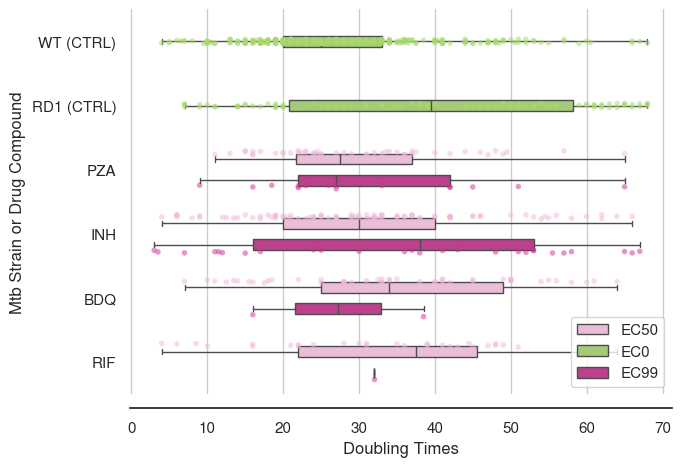

In [15]:
# Prepare the subset DataFrame, filtering for WT strain or CTRL with RD1
subset_df = df[((df['Strain'] == 'WT') | ((df['Strain'] == 'RD1') & (df['Compound'] == 'CTRL'))) 
             & (df['r2'] >= 0.8) 
             & (df['Edge Status'] == False) 
             & (df['mtb_origin'].isna())  # are we really doing this right now? or after figure 3? 
              ].drop_duplicates(subset=['ID'])

# Continue with the usual process of exploding and filtering Doubling Times
subset_df = subset_df.explode('Doubling Times')
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]
print(f'N={len(subset_df)}')

# Modify the DataFrame to place both WT and RD1 under the CTRL compound row
subset_df['Mtb Strain or Drug Compound'] = subset_df.apply(
    lambda row: f"{row['Strain']} (CTRL)" if row['Compound'] == 'CTRL' else row['Compound'], axis=1
)

# Define the desired order with WT and RD1 at the top
strain_order = ['WT (CTRL)', 'RD1 (CTRL)', 'PZA', 'INH', 'BDQ', 'RIF']

# Initialize the figure
f, ax = plt.subplots(figsize=(7, 5))

# Define hue_order for consistency
hue_order = ['EC50', 'EC0', 'EC99']

# Create the boxplot with specified y-axis order
sns.boxplot(
    data=subset_df, x="Doubling Times", y="Mtb Strain or Drug Compound", hue="Concentration", 
    whis=[0, 100], width=.5, palette= [expanded_piyg[4],expanded_piyg[1], expanded_piyg[5]], 
    hue_order=hue_order, order=strain_order
)

# Add the stripplot with the same y-axis order
sns.stripplot(
    data=subset_df, x="Doubling Times", y="Mtb Strain or Drug Compound", hue="Concentration", size=4, 
    palette=[expanded_piyg[4],expanded_piyg[1], expanded_piyg[5]], 
    hue_order=hue_order, dodge=True, alpha=0.5, order=strain_order
)

# Remove the double legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], labels[0:3])

# Tweak visual presentation
ax.xaxis.grid(True)
sns.despine(offset=10, left=True)

# Show the plot
plt.show()

N=1028


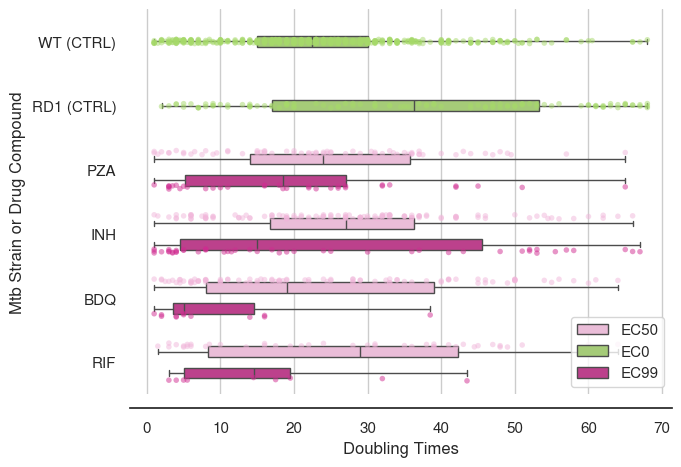

In [5]:
# Prepare the subset DataFrame as before
subset_df = df[(df['r2'] >= 0.8) 
             & (df['Edge Status'] == False) 
             & (df['Strain'] != 'UNI') 
             # & (df['Compound'] == 'CTRL')
             & (df['mtb_origin'].isna()) # are we really doing this right now? or after figure 3? 
               ].drop_duplicates(subset=['ID'])
subset_df = subset_df.explode('Doubling Times')
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]
print(f'N={len(subset_df)}')

# Modify the DataFrame to place both WT and RD1 under the CTRL compound row
subset_df['Mtb Strain or Drug Compound'] = subset_df.apply(
    lambda row: f"{row['Strain']} (CTRL)" if row['Compound'] == 'CTRL' else row['Compound'], axis=1
)

# Define the desired order with WT and RD1 at the top
strain_order = ['WT (CTRL)', 'RD1 (CTRL)', 'PZA', 'INH', 'BDQ', 'RIF']

# Initialize the figure
f, ax = plt.subplots(figsize=(7, 5))

# Define hue_order for consistency
hue_order = ['EC50', 'EC0', 'EC99']

# Create the boxplot with specified y-axis order
sns.boxplot(
    data=subset_df, x="Doubling Times", y="Mtb Strain or Drug Compound", hue="Concentration", 
    whis=[0, 100], width=.5, palette= [expanded_piyg[4],expanded_piyg[1], expanded_piyg[5]], 
    hue_order=hue_order, order=strain_order
)

# Add the stripplot with the same y-axis order
sns.stripplot(
    data=subset_df, x="Doubling Times", y="Mtb Strain or Drug Compound", hue="Concentration", size=4, 
    palette=[expanded_piyg[4],expanded_piyg[1], expanded_piyg[5]], 
    hue_order=hue_order, dodge=True, alpha=0.5, order=strain_order
)

# Remove the double legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], labels[0:3])

# Tweak visual presentation
ax.xaxis.grid(True)
sns.despine(offset=10, left=True)

# Show the plot
plt.show()

### Sort by lowest values of DT

In [6]:
IDs = subset_df.drop_duplicates('ID').sort_values('Doubling Times').ID.values

In [7]:
len(IDs)

639

In [ ]:
for i, ID in tqdm(enumerate(IDs), total = len(IDs)):
    # if i != 15:
    #     continue
    # Load the video
    glimpse_files = glob.glob(f'/mnt/SYNO/macrohet_syno/glimpses/{ID}.mp4')
    if not glimpse_files:
        print(f"Glimpse file for ID {ID} not found.")
        plt.show()
        continue

    glimpse_fn = glimpse_files[0]

    # Load the video frames using imageio
    video_frames = []
    try:
        reader = imageio.get_reader(glimpse_fn)
        for frame in reader:
            video_frames.append(frame)
        reader.close()
    except Exception as e:
        print(f"Error loading video for ID {ID}: {e}")
        plt.show()
        continue

    # Initialize the Napari viewer
    viewer = napari.Viewer(title=f'ID: {ID} - checking shortest doubling times')

    # Add the video to Napari
    video_frames_array = np.array(video_frames)
    viewer.add_image(video_frames_array, name=f'ID: {ID} Video')

    plot(ID, df, save = False, napari = True)
    viewer.grid.enabled = True
    viewer.dims.current_step = (0, 374, 374)
    
    def mark_transfer(viewer):
        df.loc[df['ID'] == ID, 'mtb_origin'] = 'Transfer'
        print(f"ID {ID} marked as 'Transfer'.")
    
    def mark_uptake(viewer):
        df.loc[df['ID'] == ID, 'mtb_origin'] = 'Uptake'
        print(f"ID {ID} marked as 'Uptake'.")
    
    def mark_junk(viewer):
        df.loc[df['ID'] == ID, 'mtb_origin'] = 'Junk'
        print(f"ID {ID} marked as 'Junk'.")

    def mark_start(viewer):
        # Get the start index from the viewer
        start_index = viewer.dims.current_step[0]
        # Identify rows to drop up to the start index
        drop_indices = df[df['ID'] == ID].index[:start_index]
        # Drop the identified rows
        df.drop(drop_indices, inplace=True)
        print(f"Start index for ID {ID} marked: {start_index}.")
    
    def mark_stop(viewer):
        # Get the stop index from the viewer
        stop_index = viewer.dims.current_step[0]
        # Identify rows to drop after the stop index
        drop_indices = df[df['ID'] == ID].index[stop_index:]
        # Drop the identified rows
        df.drop(drop_indices, inplace=True)
        print(f"Stop index for ID {ID} marked: {stop_index}.")

    def mark_edge(viewer):
        df.loc[df['ID'] == ID, 'Edge Status'] = True
        print(f"ID {ID} marked as 'Edge Status'.")
    
    def regen_dt_and_graph(viewer):
        regen(ID, df)
        plot(ID, df, save=False, napari=True)
    
    def save_df(viewer):
        df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/sc_df_update.pkl')
        print('DataFrame saved out')

    viewer.bind_key('t', mark_transfer)
    viewer.bind_key('u', mark_uptake)
    viewer.bind_key('j', mark_junk)
    viewer.bind_key('>', mark_start)
    viewer.bind_key('<', mark_stop)
    viewer.bind_key('r', regen_dt_and_graph)
    viewer.bind_key('s', save_df)
    viewer.bind_key('e', mark_edge)
    
    viewer.show(block=True)
    plt.close()
    df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/sc_df_update.pkl')

  0%|          | 0/639 [00:00<?, ?it/s]

/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 1345.3.11.ND0003 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 345.4.6.ND0003 marked as 'Uptake'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 634.5.6.PS0000 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 750.6.4.PS0000 marked: 6.
No population doubling for ID 750.6.4.PS0000
No population doubling for ID 750.6.4.PS0000


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 2261.6.10.ND0003 marked: 23.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/2261.6.10.ND0003_dtmin-1.5_r20.85_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 1453.4.4.ND0003 marked: 7.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/1453.4.4.ND0003_dtmin3.0_r20.9_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 1453.4.4.ND0003 marked: 17.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/1453.4.4.ND0003_dtmin2.5_r20.9_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 2811.3.9.ND0003 marked: 37.
Nee fitting (-0.13)
Nee fitting (-0.13)
No population doubling for ID 2811.3.9.ND0003


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2811.3.9.ND0003 marked as 'Junk'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2882.4.10.ND0003 marked as 'Transfer'.
ID 2882.4.10.ND0003 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 1232.3.4.ND0003 marked: 14.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/1232.3.4.ND0003_dtmin3.0_r20.85_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 1232.3.4.ND0003 marked: 20.
No population doubling for ID 1232.3.4.ND0003
No population doubling for ID 1232.3.4.ND0003


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 596.4.7.PS0000 marked: 8.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/596.4.7.PS0000_dtmin3.0_r20.89_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 596.4.7.PS0000 marked as 'Transfer'.
ID 596.4.7.PS0000 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 2297.3.11.ND0003 marked: 21.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/2297.3.11.ND0003_dtmin-12.5_r20.81_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2297.3.11.ND0003 marked as 'Junk'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plo

ID 3592.3.9.ND0003 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 44.3.4.ND0002 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 279.6.6.PS0000 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plo

ID 123.4.6.PS0000 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 401.3.5.PS0000 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 59.5.12.ND0003 marked: 9.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/59.5.12.ND0003_dtmin4.5_r20.91_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2364.3.3.ND0003 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2167.3.4.ND0003 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 2089.3.6.ND0003 marked: 24.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/2089.3.6.ND0003_dtmin5.0_r20.84_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 2089.3.6.ND0003 marked: 35.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/2089.3.6.ND0003_dtmin36.0_r20.76_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 673.3.8.ND0003 marked: 25.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/673.3.8.ND0003_dtmin5.0_r20.92_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 121.4.9.ND0003 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 2.4.4.PS0000 marked: 7.
No population doubling for ID 2.4.4.PS0000
No population doubling for ID 2.4.4.PS0000


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 21.5.9.PS0000 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 383.6.8.ND0003 marked: 31.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/383.6.8.ND0003_dtmin-9.0_r20.81_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 1447.4.4.ND0003 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 831.3.4.PS0000 marked: 9.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/831.3.4.PS0000_dtmin6.0_r20.95_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 1141.3.10.ND0002 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 2216.4.4.ND0002 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 192.6.9.PS0000 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 2492.4.3.ND0003 marked: 42.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/2492.4.3.ND0003_dtmin-1.0_r20.82_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plo

Start index for ID 389.6.5.PS0000 marked: 6.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/389.6.5.PS0000_dtmin-2.0_r20.95_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 389.6.5.PS0000 marked: 7.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/389.6.5.PS0000_dtmin1.0_r20.94_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 389.6.5.PS0000 marked: 24.


/tmp/ipykernel_2833334/2034410907.py:235: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/389.6.5.PS0000_dtmin4.0_r20.94_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcPar

Start index for ID 2393.6.3.ND0003 marked: 5.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/2393.6.3.ND0003_dtmin7.0_r20.81_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plo

ID 1518.3.12.ND0003 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Stop index for ID 315.3.4.ND0003 marked: 108.
Nee fitting (0.64)
Nee fitting (0.64)


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Stop index for ID 315.3.4.ND0003 marked: 97.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/315.3.4.ND0003_dtmin7.5_r20.88_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Stop index for ID 1748.5.6.ND0003 marked: 46.
Nee fitting (-0.05)
Nee fitting (-0.05)
No population doubling for ID 1748.5.6.ND0003


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 1748.5.6.ND0003 marked: 0.
Stop index for ID 1748.5.6.ND0003 marked: 79.
Nee fitting (-0.05)
Nee fitting (-0.05)
No population doubling for ID 1748.5.6.ND0003


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 1748.5.6.ND0003 marked as 'Junk'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 103.4.9.PS0000 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 271.3.7.PS0000 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 135.4.9.PS0000 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 840.6.8.PS0000 marked: 11.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/840.6.8.PS0000_dtmin4.0_r20.97_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plo

Start index for ID 2780.4.5.ND0003 marked: 11.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/2780.4.5.ND0003_dtmin8.0_r20.82_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 2780.4.5.ND0003 marked: 26.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/2780.4.5.ND0003_dtmin24.0_r20.82_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 512.5.8.PS0000 marked: 4.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/512.5.8.PS0000_dtmin-5.0_r20.88_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 512.5.8.PS0000 marked: 6.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/512.5.8.PS0000_dtmin1.0_r20.88_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 512.5.8.PS0000 marked: 11.
Nee fitting (0.69)
Nee fitting (0.69)
No population doubling for ID 512.5.8.PS0000


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 512.5.8.PS0000 marked: 4.
Nee fitting (0.35)
Nee fitting (0.35)
No population doubling for ID 512.5.8.PS0000


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plo

Start index for ID 145.3.8.PS0000 marked: 41.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/145.3.8.PS0000_dtmin-3.0_r20.87_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 1066.3.4.ND0003 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 2524.3.3.ND0003 marked: 5.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/2524.3.3.ND0003_dtmin9.5_r20.88_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plo

ID 507.3.5.PS0000 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 48.4.9.PS0000 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plo

Start index for ID 4108.4.3.ND0003 marked: 7.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/4108.4.3.ND0003_dtmin10.0_r20.82_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 4108.4.3.ND0003 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


ID 1187.4.5.ND0003 marked as 'Junk'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Stop index for ID 1725.3.11.ND0003 marked: 98.
Nee fitting (-0.75)
Nee fitting (-0.75)


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Stop index for ID 1725.3.11.ND0003 marked: 96.
Nee fitting (0.2)
Nee fitting (0.2)


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Stop index for ID 1725.3.11.ND0003 marked: 94.
Nee fitting (0.6)
Nee fitting (0.6)


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Stop index for ID 1725.3.11.ND0003 marked: 92.
Nee fitting (0.69)
Nee fitting (0.69)


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Stop index for ID 1725.3.11.ND0003 marked: 90.
Nee fitting (0.68)
Nee fitting (0.68)


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Stop index for ID 1725.3.11.ND0003 marked: 88.
Nee fitting (0.67)
Nee fitting (0.67)


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Nee fitting (0.67)
Nee fitting (0.67)


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Stop index for ID 1725.3.11.ND0003 marked: 86.
Nee fitting (0.68)
Nee fitting (0.68)


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plo

ID 129.5.6.PS0000 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plo

ID 378.4.6.PS0000 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plo

Start index for ID 3519.3.3.ND0003 marked: 21.
Nee fitting (0.57)
Nee fitting (0.57)
No population doubling for ID 3519.3.3.ND0003


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plo

Start index for ID 169.4.4.PS0000 marked: 6.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/169.4.4.PS0000_dtmin13.0_r20.94_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plo

ID 90.4.4.ND0003 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plo

ID 548.5.5.PS0000 marked as 'Transfer'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)


Start index for ID 295.6.4.PS0000 marked: 2.
Moved /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/all/295.6.4.PS0000_dtmin14.0_r20.88_graph.pdf to /mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4/arx


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plo

ID 171.4.4.ND0003 marked as 'Junk'.


/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plot_image_path)
/tmp/ipykernel_2833334/2034410907.py:156: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plot_image = imageio.imread(plo


### to correct:

401.3.5.PS0000 mark as growth?

1447.4.4.ND0003 marked as 'Transfer', mark as growth?

389.6.5.PS0000 marked: 7... should it be 24?

512.5.8.PS0000 cropped too much, should start at 4

823.4.6.PS0000 dt correct?

### to investigate:

doubling amounts

# arx - creating glimpses for outliers

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from macrohet import visualise, dataio, tile
from tqdm.auto import tqdm
import os
import btrack
import json
import napari
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import subprocess
import glob

def create_video_from_frames(input_folder, output_video, fps=5):
    # Ensure the input folder path ends with a slash
    if not input_folder.endswith('/'):
        input_folder += '/'

    # Check if there are any PNG files in the directory
    png_files = glob.glob(input_folder + '*_t_*.png')
    if not png_files:
        raise ValueError("No PNG files found in the specified directory")

    # FFmpeg command to create video
    command = [
    'ffmpeg',
    '-y', #overwrite video files without asking
    '-framerate', str(fps),
    '-pattern_type', 'glob',
    '-i', f'{input_folder}*_t_*.png',
    '-vf', 'pad=ceil(iw/2)*2:ceil(ih/2)*2',  # Adjust dimensions
    '-c:v', 'libx264',
    '-pix_fmt', 'yuv420p',
    output_video
    ]
    subprocess.run(command)

def create_rgb_image(glimpse_frame):
    # check if blank frame first by consulting the mask channel
    if np.all(glimpse_frame[0] == 0):
        rgb_image = np.zeros(glimpse_frame.shape[1:] + (3,))

        return rgb_image
    
    # Normalize each axis to range [0, 1]
    normalized = (glimpse_frame - np.min(glimpse_frame, axis=(1, 2), keepdims=True)) / \
                 (np.max(glimpse_frame, axis=(1, 2), keepdims=True) - np.min(glimpse_frame, axis=(1, 2), keepdims=True))

    # Create an empty RGB image
    rgb_image = np.zeros(normalized.shape[1:] + (3,))  # Shape (500, 500, 3)

    # Assigning the normalized channels to the corresponding RGB channels
    # Cyan: First axis (Green + Blue)
    rgb_image[..., 1] += normalized[0]  # Green channel
    rgb_image[..., 2] += normalized[0]  # Blue channel
    
    # Green: Second axis (Green)
    rgb_image[..., 1] += normalized[1]
    
    # Magenta: Third axis (Red + Blue)
    rgb_image[..., 0] += normalized[2]  # Red channel
    rgb_image[..., 2] += normalized[2]  # Blue channel
    
    # Clipping values to ensure they are within [0, 1]
    rgb_image = np.clip(rgb_image, 0, 1)

    return rgb_image


# Function to calculate gradient for a window
def calculate_gradient(window):
    y = window
    x = np.arange(len(window))
    slope, _ = np.polyfit(x, y, 1)
    return slope

### Set style for plotting

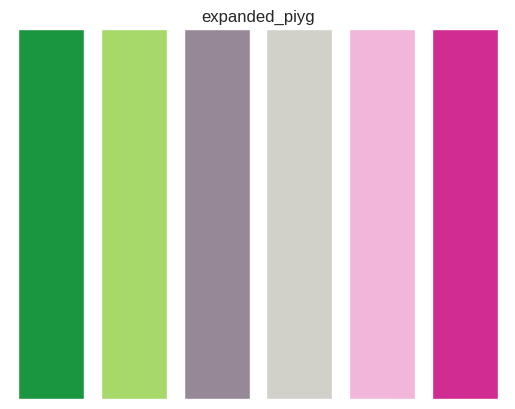

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [3]:
sns.set(style = 'white')

# Set the default font to Helvetica
mpl.rcParams['font.family'] = 'Liberation Sans'

# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)

### Load sc df

In [4]:
df = pd.read_pickle('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_GT_70_interp.pkl')
df['dMtb'] = df['delta Mtb max fold-change normalised max area']
df['Mtb'] = df['Intracellular thresholded Mtb content smooth']
# Assuming your DataFrame is named 'df'
df['Strain/Compound'] = df['Compound']  # Create a new column and copy values from 'Compound'
# Replace values in 'NewColumn' where 'Strain' is 'RD1' with 'RD1'
df.loc[df['Strain'] == 'RD1', 'Strain/Compound'] = 'RD1'
df

Time (hours)           x            y     x scaled     y scaled  \
0                  0  457.172943     8.791715  2304.151633    44.310242   
1                  1  459.138947     6.718642  2314.060291    33.861954   
2                  2  460.555237    10.785886  2321.198394    54.360864   
3                  3  455.878815    11.143067  2297.629226    56.161059   
4                  4  462.634186    14.050420  2331.676296    70.814116   
...              ...         ...          ...          ...          ...   
296992            70  628.562500  1099.782104  3167.955000  5542.901807   
296993            71  628.463684  1102.144409  3167.456968  5554.807822   
296994            72  628.672058  1101.594727  3168.507173  5552.037422   
296995            73  630.372803  1102.817749  3177.078926  5558.201455   
296996            74  631.163696  1100.681519  3181.065029  5547.434854   

        Infection status  Initial infection status  Final infection status  \
0                    1.0                       1.0                     0.0   
1                    0.0                       1.0                     0.0   
2                    0.0                       1.0                     0.0   
3                    1.0                       1.0                     0.0   
4                    1.0                       1.0                     0.0   
...                  ...                       ...                     ...   
296992               1.0                       0.0                     1.0   
296993               1.0                       0.0                     1.0   
296994               1.0                       0.0                     1.0   
296995               1.0                       0.0                     1.0   
296996               1.0                       0.0                     1.0   

            Area  Intracellular mean Mtb content  ...  Strain  Compound  \
0        20542.0                      343.157196  ...     RD1      CTRL   
1        16683.0                      344.687042  ...     RD1      CTRL   
2        18935.0                      343.875061  ...     RD1      CTRL   
3        19937.0                      345.565796  ...     RD1      CTRL   
4        21793.0                      350.585083  ...     RD1      CTRL   
...          ...                             ...  ...     ...       ...   
296992  101991.0                      377.731873  ...      WT       BDQ   
296993  100978.0                      377.812103  ...      WT       BDQ   
296994  108397.0                      376.812805  ...      WT       BDQ   
296995  107079.0                      377.437073  ...      WT       BDQ   
296996  101298.0                      377.184937  ...      WT       BDQ   

        Concentration  Technical replicate  Cell ID  Acquisition ID  \
0                 EC0                    1      426          (3, 4)   
1                 EC0                    1      426          (3, 4)   
2                 EC0                    1      426          (3, 4)   
3                 EC0                    1      426          (3, 4)   
4                 EC0                    1      426          (3, 4)   
...               ...                  ...      ...             ...   
296992           EC99                    2      935          (6, 9)   
296993           EC99                    2      935          (6, 9)   
296994           EC99                    2      935          (6, 9)   
296995           EC99                    2      935          (6, 9)   
296996           EC99                    2      935          (6, 9)   

        Unique ID      dMtb       Mtb  Strain/Compound  
0         426.3.4  0.000586  0.912650              RD1  
1         426.3.4  0.000586  0.912650              RD1  
2         426.3.4  0.000586  0.912650              RD1  
3         426.3.4  0.000586  0.912650              RD1  
4         426.3.4  0.000586  0.912650              RD1  
...           ...       ...       ...              ...  
296992    935.6.9

### Calculate the maximum gradient for each cell

In [5]:
# df['Max. dMtb gradient'] = np.nan  # Initialize with NaN instead of None
for unique_ID in tqdm(df['Unique ID'].unique()):
    sc_df = df[df['Unique ID'] == unique_ID]

    max_gradient = sc_df['Mtb'].rolling(window=15).apply(calculate_gradient, raw=True).max()
    df.loc[df['Unique ID'] == unique_ID, 'Max. dMtb gradient'] = max_gradient
    if max_gradient > 120:
        print(unique_ID)

  0%|          | 0/3988 [00:00<?, ?it/s]

280.3.5
85.4.5


### Load metadata

In [6]:
base_dir = '/mnt/DATA/macrohet/'
metadata_path = os.path.join(base_dir, 'macrohet_images/PS0000/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
4   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
5   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99
6   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99

In [7]:
base_dir = '/mnt/DATA/macrohet/macrohet_images/PS0000/'
metadata_fn = os.path.join(base_dir, 'Images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


id State                              URL Row Col FieldID  \
0        0303K1F1P1R1    Ok   r03c03f01p01-ch1sk1fk1fl1.tiff   3   3       1   
1        0303K1F1P1R2    Ok   r03c03f01p01-ch2sk1fk1fl1.tiff   3   3       1   
2        0303K1F1P2R1    Ok   r03c03f01p02-ch1sk1fk1fl1.tiff   3   3       1   
3        0303K1F1P2R2    Ok   r03c03f01p02-ch2sk1fk1fl1.tiff   3   3       1   
4        0303K1F1P3R1    Ok   r03c03f01p03-ch1sk1fk1fl1.tiff   3   3       1   
...               ...   ...                              ...  ..  ..     ...   
113395  0609K75F9P1R2    Ok  r06c09f09p01-ch2sk75fk1fl1.tiff   6   9       9   
113396  0609K75F9P2R1    Ok  r06c09f09p02-ch1sk75fk1fl1.tiff   6   9       9   
113397  0609K75F9P2R2    Ok  r06c09f09p02-ch2sk75fk1fl1.tiff   6   9       9   
113398  0609K75F9P3R1    Ok  r06c09f09p03-ch1sk75fk1fl1.tiff   6   9       9   
113399  0609K75F9P3R2    Ok  r06c09f09p03-ch2sk75fk1fl1.tiff   6   9       9   

       PlaneID TimepointID ChannelID FlimID  ... PositionZ AbsPositionZ  \
0            1           0         1      1  ...         0  0.135583505   
1            1           0         2      1  ...         0  0.135583505   
2            2           0         1      1  ...     2E-06  0.135585502   
3            2           0         2      1  ...     2E-06  0.135585502   
4            3           0         1      1  ...     4E-06  0.135587499   
...        ...         ...       ...    ...  ...       ...          ...   
113395       1          74         2      1  ...         0  0.135533601   
113396       2          74         1      1  ...     2E-06  0.135535598   
113397       2          74         2      1  ...     2E-06  0.135535598   
113398       3          74         1      1  ...     4E-06  0.135537595   
113399       3          74         2      1  ...     4E-06  0.135537595   

       MeasurementTimeOffset                        AbsTime  \
0                          0   2021-04-16T19:09:33.84+01:00   
1                          0   2021-04-16T19:09:33.84+01:00   
2                          0   2021-04-16T19:09:34.12+01:00   
3                          0   2021-04-16T19:09:34.12+01:00   
4                          0    2021-04-16T19:09:34.4+01:00   
...                      ...                            ...   
113395             266399.61  2021-04-19T21:14:19.477+01:00   
113396             266399.61  2021-04-19T21:14:19.757+01:00   
113397             266399.61  2021-04-19T21:14:19.757+01:00   
113398             266399.61  2021-04-19T21:14:20.037+01:00   
113399             266399.61  2021-04-19T21:14:20.037+01:00   

       MainExcitationWavelength MainEmissionWavelength ObjectiveMagnification  \
0                           488                    522                     40   
1                           640                    706                     40   
2                           488                    522                     40   
3                           640                    706                     40   
4                           488                    522                     40   
...                         ...                    ...                    ...   
113395                      640                    706                     40   
113396                      488                    522                     40   
113397                      640                    706                     40   
113398                      488                    522                     40   
113399                      640                    706                     40   

       ObjectiveNA ExposureTime  \
0              1.1          0.1   
1              1.1          0.2   
2              1.1          0.1   
3              1.1          0.2   
4              1.1          0.1   
...            ...          ...   
113395         1.1          0.2   
113396         1.1          0.1   
113397         1.1          0.2   
113398         1.1          0.1   
113399         1.1          0.2   

      

## Load outliers

In [8]:
N = 100
top_N_tracks = df.groupby('Unique ID')['Max. dMtb gradient'].max().sort_values(ascending=False).head(N)

## Plot some outliers

In [ ]:

# Plot 'Mtb' and the calculated gradient against 'Time (hours)' for each of the top ten tracks
for n, track_id in tqdm(enumerate(top_N_tracks.keys()), total = len(top_N_tracks.keys())):
    
    if n == 10:
        break
    # Extract rows corresponding to the current track
    track_data = df[df['Unique ID'] == track_id]

    # Convert to NumPy array for compatibility
    time_values = track_data['Time (hours)'].values
    mtb_values = track_data['Mtb'].values
    gradient_values = track_data['Mtb'].rolling(window=15).apply(calculate_gradient, raw=True).values

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Plot Mtb values
    color = expanded_piyg[0]
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Mtb Value', color=color)
    ax1.plot(time_values, mtb_values, label=f'Intracellular Mtb (Unique ID: {track_id})', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a twin axis for the gradient
    ax2 = ax1.twinx() 
    color = expanded_piyg[-1]
    ax2.set_ylabel('Gradient', color=color)  
    ax2.plot(time_values, gradient_values, label='Gradient', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax1.legend(loc='upper left')
    ax2.legend(loc='lower right')

    plt.title(f'Mtb and Gradient vs Time for Track {track_id}')
    fig.tight_layout()
    sns.despine(offset = 10, right = False)
    plt.show()

    # get acq ID and ID from track id'
    acq_ID = track_data['Acquisition ID'].iloc[0]
    cell_ID = track_data['Cell ID'].iloc[0]
    # get images 
    row, column = acq_ID
    image_dir = os.path.join(base_dir, 'Images')
    images = tile.compile_mosaic(image_dir, 
                                 metadata, 
                                 row, column, 
                                 set_plane='max_proj',
                                 # set_channel=1,
                                 # set_time = 1,
    #                             input_transforms = [input_transforms]
                                )#.compute().compute()
    glimpse = visualise.create_glimpse_from_sc_df(track_data, acq_ID, cell_ID, images)
    loaded_glimpse = glimpse.compute().compute()
    glimpse_dict[track_id] = loaded_glimpse

    filename = f"{directory}{track_id}.npy"
    
    # Save the image
    np.save(filename, loaded_glimpse)

    # Store the filename in the dictionary
    filenames_dict[key] = filename

## Load segmentation

In [9]:
tracks_dict = dict()
segmentation_dict = dict()

### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(f'/mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/{row,column}.h5', 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
        seg = reader.segmentation

            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks
    segmentation_dict[(row, column)] = seg

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/11/27 12:09:14 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5...
[INFO][2023/11/27 12:09:14 PM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2023/11/27 12:09:14 PM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2023/11/27 12:09:14 PM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/11/27 12:09:25 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/11/27 12:09:25 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5
[INFO][2023/11/27 12:09:25 PM] Opening HDF file: /mnt/DATA/macrohet/labels/P

# Plot all outliers and save out as graph glimpse combination

In [1]:
output_folder = '/mnt/DATA/macrohet/results/glimpses/fast_grower_graph/'

In [1]:
physical_length_m = 10E-6
resolution_m_per_pixel = 1.47E-7
size = 500

In [ ]:
# Plot 'Mtb' and the calculated gradient against 'Time (hours)' for each of the top ten tracks
for n, track_id in tqdm(enumerate(top_N_tracks.keys()), total = len(top_N_tracks.keys()), desc = 'Iterating over top growth outliers'):
    
    
    # Extract rows corresponding to the current track
    track_data = df[df['Unique ID'] == track_id]

    # get acq ID and ID from track id'
    acq_ID = track_data['Acquisition ID'].iloc[0]
    cell_ID = track_data['Cell ID'].iloc[0]
    
    # define output prior to checking if already created mp4 for this example 
    output_folder = f'/mnt/DATA/macrohet/results/glimpses/fast_grower_graph/{acq_ID}/{track_id}'
    if os.path.exists(f"{output_folder}/ID_{track_id}_outlying_growth_glimpse_graph.mp4"):
        continue
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    frame_output_folder = os.path.join(output_folder, 'frames')
    if not os.path.exists(frame_output_folder):
        os.makedirs(frame_output_folder)
    
    # get glimpse
    # if track_id not in glimpse_dict:
    # get images 
    print('Generating glimpse')
    row, column = acq_ID
    image_dir = os.path.join(base_dir, 'Images')
    images = tile.compile_mosaic(image_dir, 
                                 metadata, 
                                 row, column, 
                                 set_plane='max_proj',
                                 # set_channel=1,
                                 # set_time = 1,
    #                             input_transforms = [input_transforms]
                                )#.compute().compute()
    glimpse = visualise.create_glimpse_from_sc_df(track_data, acq_ID, cell_ID, images)
    loaded_glimpse = glimpse.compute().compute()
    # glimpse_dict[track_id] = loaded_glimpse

    # else:
    #     print('Loading glimpse')
    #     loaded_glimpse = glimpse_dict[track_id]
    
    mask_glimpse = visualise.create_mask_glimpse_from_sc_df(track_data, acq_ID, cell_ID, segmentation_dict[acq_ID])
    mask_glimpse_expanded = np.expand_dims(mask_glimpse, axis=0)
    final_glimpse = np.concatenate((mask_glimpse_expanded, loaded_glimpse), axis = 0)
    
    output_folder = f'/mnt/DATA/macrohet/results/glimpses/fast_grower_graph/{acq_ID}/{track_id}'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    frame_output_folder = os.path.join(output_folder, 'frames')
    if not os.path.exists(frame_output_folder):
        os.makedirs(frame_output_folder)
    
    time_values = track_data['Time (hours)'].values
    mtb_values = track_data['Mtb'].values
    gradient_values = track_data['Mtb'].rolling(window=15).apply(calculate_gradient, raw=True).values
    scale_bar_length_pixels = int(physical_length_m / resolution_m_per_pixel)
    
    for frame_index in tqdm(range(final_glimpse.shape[1]), desc = 'Saving out single frames'):
        fig, ax1 = plt.subplots(figsize=(10, 4))
    
        # Plot Mtb values and Gradient on twin axes
        ax1.set_xlabel('Time (hours)', fontweight='semibold')
        ax1.set_ylabel('Intracellular Mtb content \n(thresholded pixel value)', color=expanded_piyg[0], fontweight='semibold')
        ax1.plot(time_values, mtb_values, label='Intracellular Mtb', color=expanded_piyg[0])
        ax1.tick_params(axis='y', labelcolor=expanded_piyg[0])
        ax2 = ax1.twinx()
        ax2.set_ylabel('Mtb growth rate \n(gradient of pixel value)', color=expanded_piyg[-1], fontweight='semibold')
        ax2.plot(time_values, gradient_values, label='Gradient', color=expanded_piyg[-1])
        ax2.tick_params(axis='y', labelcolor=expanded_piyg[-1])
        
        # Vertical line
        vline = ax1.axvline(x=time_values[frame_index], color='k', linestyle='--')
        # add title 
        plt.title(f'Intracellular Mtb measure and growth rate \nMacrophage ID: {track_id}', fontsize=16, fontweight='bold')
    
        # Add RGB image
        image_ax = fig.add_axes([0.89, 0.1, 0.55, 0.8])  # Adjust as needed
        rgb_image = create_rgb_image(final_glimpse[:, frame_index, ...])
        image_ax.imshow(rgb_image)
        image_ax.axis('off')
    
        # Position of the scale bar (bottom right corner)
        x_position = rgb_image.shape[1] - scale_bar_length_pixels - 20  # 20 pixels from the right edge
        y_position = rgb_image.shape[0] - 20  # 20 pixels from the bottom edge
        
        # Create a rectangle patch for the scale bar
        scale_bar = patches.Rectangle((x_position, y_position), scale_bar_length_pixels, 3, color='white')
        
        # Add the scale bar to the image
        image_ax.add_patch(scale_bar)
        
        # Optionally, add text to label the scale bar
        scale_bar_physical_length = "10 µm"
        plt.text(x_position, y_position - 10, scale_bar_physical_length, color='white', fontsize=12, fontweight='semibold')
        
        # Add a timestamp on the bottom left corner of the image
        timestamp_position_x = 20  # 20 pixels from the left edge
        timestamp_position_y = rgb_image.shape[0] - 32  # 20 pixels from the bottom edge
        timestamp_text = f"{time_values[frame_index]:.2f} hours"  # Format the time with 2 decimal places
        plt.text(timestamp_position_x, timestamp_position_y, timestamp_text, color='white', fontsize=12, transform=image_ax.transData, fontweight='semibold')
        
        # Retrieve the data for overlay text
        row_data = assay_layout.loc[acq_ID]  # Adjust the index as per your requirements
        strain = row_data['Strain']
        compound = row_data['Compound']
        concentration_ec = row_data['ConcentrationEC']
    
        # Overlay text on the image
        overlay_text = f"Strain: {strain}\nCompound: {compound}\nConcentrationEC: {concentration_ec}"
        image_ax.text(10, size+90, overlay_text, color='black', fontsize=12, transform=image_ax.transData, fontweight='semibold')
        
        sns.despine(offset = 10, right = False)
        
        # Save each frame plot
        zfill_time = f'{time_values[frame_index]}'.zfill(len(str(time_values.max())))
        plt.savefig(f"{output_folder}/frames/ID_{track_id}_t_{zfill_time}.png", bbox_inches = 'tight', dpi = 314)
        # plt.show()
        plt.clf()
        
    # Create mp4 video
    create_video_from_frames(f"{output_folder}/frames/", f"{output_folder}/ID_{track_id}_outlying_growth_glimpse_graph.mp4", fps=5)

Iterating over top growth outliers:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (5, 5, 'max_proj', None, None) 


Generating glimpse


Stitching images together:   0%|          | 0/450 [00:00<?, ?it/s]

Creating glimpse ID: ((5, 5), 387):   0%|          | 0/74 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 283
  return da_func(*args, **kwargs)


# mtb area arx 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from macrohet import visualise, dataio, tile
from tqdm.auto import tqdm
import os
import btrack
import json
import napari
import matplotlib as mpl
import matplotlib.patches as patches
import pickle
import glob
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import subprocess
from scipy.interpolate import UnivariateSpline
import glob
scale_factor = 6048/1200

# Function to calculate gradient for a window
def calculate_gradient(window):
    y = window
    x = np.arange(len(window))
    slope, _ = np.polyfit(x, y, 1)
    return slope

def find_doubling_points(time_values, mtb_values, min_mtb_value):
    # Check if any value doubles within the series
    for i in range(len(mtb_values)):
        q1 = mtb_values[i]
        t1 = time_values[i]
        
        # Skip if the mtb value is below the minimum threshold
        if q1 < min_mtb_value:
            continue
        
        for j in range(i + 1, len(mtb_values)):
            q2 = mtb_values[j]
            t2 = time_values[j]
            
            # Check if q2 is at least double q1
            if q2 >= 2 * q1:
                return t1, t2, q1, q2
    return None, None, None, None  # If no doubling is found

def create_video_from_frames(input_folder, output_video, fps=5):
    # Ensure the input folder path ends with a slash
    if not input_folder.endswith('/'):
        input_folder += '/'

    # Check if there are any PNG files in the directory
    png_files = glob.glob(input_folder + '*_t_*.png')
    if not png_files:
        raise ValueError("No PNG files found in the specified directory")

    # FFmpeg command to create video
    command = [
    'ffmpeg',
    '-y', #overwrite video files without asking
    '-framerate', str(fps),
    '-pattern_type', 'glob',
    '-i', f'{input_folder}*_t_*.png',
    '-vf', 'pad=ceil(iw/2)*2:ceil(ih/2)*2',  # Adjust dimensions
    '-c:v', 'libx264',
    '-pix_fmt', 'yuv420p',
    output_video
    ]
    subprocess.run(command)

def create_rgb_image(glimpse_frame):
    # check if blank frame first by consulting the mask channel
    if np.all(glimpse_frame[0] == 0):
        rgb_image = np.zeros(glimpse_frame.shape[1:] + (3,))

        return rgb_image
    
    # Normalize each axis to range [0, 1]
    normalized = (glimpse_frame - np.min(glimpse_frame, axis=(1, 2), keepdims=True)) / \
                 (np.max(glimpse_frame, axis=(1, 2), keepdims=True) - np.min(glimpse_frame, axis=(1, 2), keepdims=True))

    # Create an empty RGB image
    rgb_image = np.zeros(normalized.shape[1:] + (3,))  # Shape (500, 500, 3)

    # Assigning the normalized channels to the corresponding RGB channels
    # Cyan: First axis (Green + Blue)
    rgb_image[..., 1] += normalized[0]  # Green channel
    rgb_image[..., 2] += normalized[0]  # Blue channel
    
    # Green: Second axis (Green)
    rgb_image[..., 1] += normalized[1]
    
    # Magenta: Third axis (Red + Blue)
    rgb_image[..., 0] += normalized[2]  # Red channel
    rgb_image[..., 2] += normalized[2]  # Blue channel
    
    # Clipping values to ensure they are within [0, 1]
    rgb_image = np.clip(rgb_image, 0, 1)

    return rgb_image

### Set style for plotting

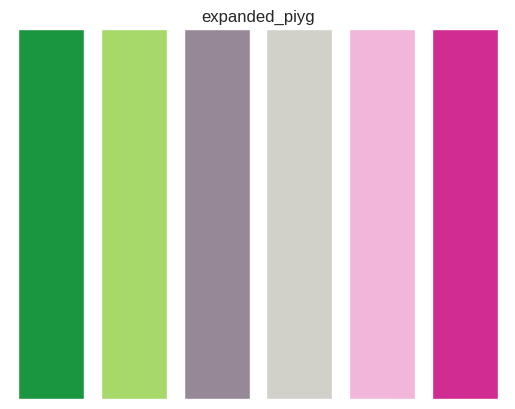

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [2]:
sns.set(style = 'white')

# Set the default font to Helvetica
mpl.rcParams['font.family'] = 'Liberation Sans'

# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)

### Load sc df

In [3]:
df = pd.read_pickle('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_GT_70_area.pkl')
# df['dMtb'] = df['delta Mtb max fold-change normalised max area']
# df['Mtb'] = df['Intracellular thresholded Mtb content smooth']
# Assuming your DataFrame is named 'df'
# df['Strain/Compound'] = df['Compound']  # Create a new column and copy values from 'Compound'
# # Replace values in 'NewColumn' where 'Strain' is 'RD1' with 'RD1'
# df.loc[df['Strain'] == 'RD1', 'Strain/Compound'] = 'RD1'
df

Time (hours)   Mtb Area        dMtb Strain Compound Concentration  \
0                  0  46.797680  136.772588     WT     CTRL           EC0   
1                  1  48.719647  136.772588     WT     CTRL           EC0   
2                  2  52.206007  136.772588     WT     CTRL           EC0   
3                  3  50.552221  136.772588     WT     CTRL           EC0   
4                  4  54.463202  136.772588     WT     CTRL           EC0   
...              ...        ...         ...    ...      ...           ...   
296992            70   0.000000   -3.888632     WT     CTRL           EC0   
296993            71   0.000000   -3.888632     WT     CTRL           EC0   
296994            72   0.000000   -3.888632     WT     CTRL           EC0   
296995            73   0.000000   -3.888632     WT     CTRL           EC0   
296996            74   0.000000   -3.888632     WT     CTRL           EC0   

       Unique ID Acquisition ID  Cell ID  Mphi Area  ...   dMtb/dt  %dMtb/dt  \
0          1.3.5         (3, 5)        1    29567.0  ...  0.000000  0.000000   
1          1.3.5         (3, 5)        1    26181.0  ...  1.921968  4.106972   
2          1.3.5         (3, 5)        1    26043.0  ...  3.486360  7.155963   
3          1.3.5         (3, 5)        1    25605.0  ... -1.653786 -3.167808   
4          1.3.5         (3, 5)        1    26430.0  ...  3.910981  7.736516   
...          ...            ...      ...        ...  ...       ...       ...   
296992   996.4.5         (4, 5)      996    32533.0  ...  0.000000  0.000000   
296993   996.4.5         (4, 5)      996    31403.0  ...  0.000000  0.000000   
296994   996.4.5         (4, 5)      996    33239.0  ...  0.000000  0.000000   
296995   996.4.5         (4, 5)      996    42445.0  ...  0.000000  0.000000   
296996   996.4.5         (4, 5)      996    35463.0  ...  0.000000  0.000000   

            %dMtb  Mean Mtb Intensity  Thresholded Mean Mtb Intensity  \
0       292.26361          473.168976                      167.325424   
1       292.26361          498.701813                      202.661972   
2       292.26361          502.468353                      210.382874   
3       292.26361          501.905182                      212.070969   
4       292.26361          502.564423                      204.565842   
...           ...                 ...                             ...   
296992 -100.00000          385.325806                        1.178588   
296993 -100.00000          384.643707                        1.152374   
296994 -100.00000          384.512726                        1.103884   
296995 -100.00000          383.335663                        0.893816   
296996 -100.00000          384.480499                        0.864845   

        Infection Status Initial Infection Status  Final Infection Status  \
0                   True                     True                    True   
1                   True                     True                    True   
2                   True                     True                    True   
3                   True                     True                    True   
4                   True                     True                    True   
...                  ...                      ...                     ...   
296992              True                     True                   False   
296993              True                     True                   False   
296994              True                     True                   False   
296995              True                     True                   False   
296996              True                     True                   False   

        dMtb/dt,T=15  Max. dMtb/dt,T=15  
0                NaN           6.314185  
1                NaN           6.314185  
2                NaN           6.314185  
3                NaN           6.314185  
4                NaN           6.314185  
...              ...                ...  
296992           0.0      

In [4]:
df.keys()

Index(['Time (hours)', 'Mtb Area', 'dMtb', 'Strain', 'Compound',
       'Concentration', 'Unique ID', 'Acquisition ID', 'Cell ID', 'Mphi Area',
       'Mphi GFP', 'x', 'y', 'Eccentricity', 'MSD', 'Technical Replicate',
       'Strain/Compound', 'dMtb/dt', '%dMtb/dt', '%dMtb', 'Mean Mtb Intensity',
       'Thresholded Mean Mtb Intensity', 'Infection Status',
       'Initial Infection Status', 'Final Infection Status', 'dMtb/dt,T=15',
       'Max. dMtb/dt,T=15'],
      dtype='object')

### Isolate the top N fastest growers

In [5]:
N = 1000
top_N_tracks = df.groupby('Unique ID')['Max. dMtb/dt,T=15'].max().sort_values(ascending=False).head(N)

In [6]:
top_N_tracks

Unique ID
624.5.5    819.733333
280.3.5    664.600000
105.3.5    571.733333
11.4.5     548.533333
169.6.5    508.600000
              ...    
665.4.8      1.665705
621.3.7      1.665705
449.4.9      1.665705
578.3.6      1.662726
823.4.6      1.661236
Name: Max. dMtb/dt,T=15, Length: 1000, dtype: float64

In [7]:
base_dir = '/mnt/DATA/macrohet/macrohet_images/PS0000/'
metadata_path = os.path.join(base_dir, 'Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
4   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
5   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99
6   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99

In [8]:
metadata_fn = os.path.join(base_dir, 'Images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


id State                              URL Row Col FieldID  \
0        0303K1F1P1R1    Ok   r03c03f01p01-ch1sk1fk1fl1.tiff   3   3       1   
1        0303K1F1P1R2    Ok   r03c03f01p01-ch2sk1fk1fl1.tiff   3   3       1   
2        0303K1F1P2R1    Ok   r03c03f01p02-ch1sk1fk1fl1.tiff   3   3       1   
3        0303K1F1P2R2    Ok   r03c03f01p02-ch2sk1fk1fl1.tiff   3   3       1   
4        0303K1F1P3R1    Ok   r03c03f01p03-ch1sk1fk1fl1.tiff   3   3       1   
...               ...   ...                              ...  ..  ..     ...   
113395  0609K75F9P1R2    Ok  r06c09f09p01-ch2sk75fk1fl1.tiff   6   9       9   
113396  0609K75F9P2R1    Ok  r06c09f09p02-ch1sk75fk1fl1.tiff   6   9       9   
113397  0609K75F9P2R2    Ok  r06c09f09p02-ch2sk75fk1fl1.tiff   6   9       9   
113398  0609K75F9P3R1    Ok  r06c09f09p03-ch1sk75fk1fl1.tiff   6   9       9   
113399  0609K75F9P3R2    Ok  r06c09f09p03-ch2sk75fk1fl1.tiff   6   9       9   

       PlaneID TimepointID ChannelID FlimID  ... PositionZ AbsPositionZ  \
0            1           0         1      1  ...         0  0.135583505   
1            1           0         2      1  ...         0  0.135583505   
2            2           0         1      1  ...     2E-06  0.135585502   
3            2           0         2      1  ...     2E-06  0.135585502   
4            3           0         1      1  ...     4E-06  0.135587499   
...        ...         ...       ...    ...  ...       ...          ...   
113395       1          74         2      1  ...         0  0.135533601   
113396       2          74         1      1  ...     2E-06  0.135535598   
113397       2          74         2      1  ...     2E-06  0.135535598   
113398       3          74         1      1  ...     4E-06  0.135537595   
113399       3          74         2      1  ...     4E-06  0.135537595   

       MeasurementTimeOffset                        AbsTime  \
0                          0   2021-04-16T19:09:33.84+01:00   
1                          0   2021-04-16T19:09:33.84+01:00   
2                          0   2021-04-16T19:09:34.12+01:00   
3                          0   2021-04-16T19:09:34.12+01:00   
4                          0    2021-04-16T19:09:34.4+01:00   
...                      ...                            ...   
113395             266399.61  2021-04-19T21:14:19.477+01:00   
113396             266399.61  2021-04-19T21:14:19.757+01:00   
113397             266399.61  2021-04-19T21:14:19.757+01:00   
113398             266399.61  2021-04-19T21:14:20.037+01:00   
113399             266399.61  2021-04-19T21:14:20.037+01:00   

       MainExcitationWavelength MainEmissionWavelength ObjectiveMagnification  \
0                           488                    522                     40   
1                           640                    706                     40   
2                           488                    522                     40   
3                           640                    706                     40   
4                           488                    522                     40   
...                         ...                    ...                    ...   
113395                      640                    706                     40   
113396                      488                    522                     40   
113397                      640                    706                     40   
113398                      488                    522                     40   
113399                      640                    706                     40   

       ObjectiveNA ExposureTime  \
0              1.1          0.1   
1              1.1          0.2   
2              1.1          0.1   
3              1.1          0.2   
4              1.1          0.1   
...            ...          ...   
113395         1.1          0.2   
113396         1.1          0.1   
113397         1.1          0.2   
113398         1.1          0.1   
113399         1.1          0.2   

      

In [15]:
mtb_areas_dict = {}
segmentation_dict = dict()
# with open('mtb_areas_dict.pkl', 'rb') as file:
#     mtb_areas_dict = pickle.load(file)
# # len(mtb_areas_dict)

In [10]:
image_dir = os.path.join(base_dir, 'Images')

In [11]:
physical_length_m = 10E-6
resolution_m_per_pixel = 1.4949402023919043E-07
size = 500
min_mtb_area = 88 * ((resolution_m_per_pixel * 1000000) ** 2) # in um2
window = 4

In [16]:
# Plot 'Mtb' and the calculated gradient against 'Time (hours)' for each of the top ten tracks
for n, track_id in tqdm(enumerate(top_N_tracks.keys()), total = len(top_N_tracks.keys()), desc = 'Iterating over top growth outliers'):
    # Extract rows corresponding to the current track
    track_data = df[df['Unique ID'] == track_id]
    
    # get acq ID and ID from track id'
    acq_ID = track_data['Acquisition ID'].iloc[0]
    cell_ID = track_data['Cell ID'].iloc[0]
    row, column = acq_ID
    
    # define output prior to checking if already created mp4 for this example 
    output_folder = f'/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/{acq_ID}/{track_id}'
    pre_made_glimpse_list = glob.glob(f"{output_folder}/ID_{track_id}*.mp4")
    if pre_made_glimpse_list:
        print(f'The following glimpses already exist for {track_id}: {pre_made_glimpse_list}')
        continue
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    frame_output_folder = os.path.join(output_folder, 'frames')
    if not os.path.exists(frame_output_folder):
        os.makedirs(frame_output_folder)
        
    # pre load images
    images = tile.compile_mosaic(image_dir, 
                         metadata, 
                         row, column, 
                         set_plane='max_proj',
                        )

    # get glimpse if already created
    if track_id+'.npy' in os.listdir('./outliers'):
        print('Loading pre generated glimpse')
        glimpse = np.load(os.path.join(f'./outliers/{track_id}.npy'))
    # or generate
    else:
        print('Generating glimpse')
        glimpse = visualise.create_glimpse_from_sc_df(track_data, acq_ID, cell_ID, images).compute().compute()

    # check if masks have been loaded
    if not acq_ID in segmentation_dict.keys():
        ### load tracks
        with btrack.io.HDF5FileHandler(f'/mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/{row,column}.h5', 
                                           'r', 
                                           obj_type='obj_type_1'
                                           ) as reader:
            seg = reader.segmentation
        ### append tracks to dictionary
        segmentation_dict[(row, column)] = seg
    # get associated masks
    masks = segmentation_dict[acq_ID]
    mask_glimpse = visualise.create_mask_glimpse_from_sc_df(track_data, acq_ID, cell_ID, masks)
    mask_glimpse_expanded = np.expand_dims(mask_glimpse, axis=0)
    final_glimpse = np.concatenate((mask_glimpse_expanded, glimpse), axis = 0)

    # now check if mtb areas already calculated
    if track_id in mtb_areas_dict.keys():
        # load if already measured
        print('Loading mtb areas')
        mtb_areas = mtb_areas_dict[track_id]
    else:
        mtb_areas = []
        for df_row in tqdm(track_data.iterrows(), total=len(track_data),
                desc=f'Extracting mtb area over each frame: {acq_ID, cell_ID}'):
            # get coords
            t, y, x = df_row[1]['Time (hours)'], int(df_row[1]['y']), int(df_row[1]['x'])
            y, x = int(y*scale_factor), int(x*scale_factor)
            # select proper frame
            frame = masks[t, ...]
            # check to see if mask exists
            if frame[y, x]:
                # select cell of interest
                mask = frame == frame[y, x]
                # get mtb channel at set frame
                images = tile.compile_mosaic(image_dir, 
                                             metadata, 
                                             row, column, 
                                             set_plane='max_proj',
                                             set_channel=2,
                                             set_time=t
                                                )[0, 0]
                # only load the crop bounding box necessary
                rows = np.any(mask, axis=1)
                cols = np.any(mask, axis=0)
                # Bounding box's top and bottom
                ymin, ymax = np.where(rows)[0][[0, -1]]
                # Bounding box's left and right
                xmin, xmax = np.where(cols)[0][[0, -1]]
                # The bounding box is defined by the coordinates (xmin, ymin) and (xmax, ymax)
                bounding_box = (xmin, ymin, xmax, ymax)
                bounded_image = images[ymin:ymax+1, xmin:xmax+1].compute().compute()
                bounded_mask = mask[ymin:ymax+1, xmin:xmax+1]
                masked_image = bounded_image*bounded_mask 
                thresholded_masked_image = masked_image >=480
                mtb_area = np.sum(thresholded_masked_image)
                # convert area from pixel to um2 
                mtb_area = mtb_area * ((resolution_m_per_pixel * 1000000) ** 2)
                mtb_areas.append(mtb_area)
            else:
                mtb_areas.append(0)  # Append 0 if no mask exists
            
            mtb_areas_dict[track_id] = mtb_areas
            # Save the dictionary to a file
            with open('mtb_areas_dict.pkl', 'wb') as file:
                pickle.dump(mtb_areas_dict, file)
        
    # get varialbes to plot 
    time_values = track_data['Time (hours)'].values
    mtb_values = pd.Series(mtb_areas).values #track_data['Mtb'].values
    gradient_values = pd.Series(mtb_areas).rolling(window=2, center=True).apply(calculate_gradient, raw=True).values #track_data['Mtb']
    scale_bar_length_pixels = int(physical_length_m / resolution_m_per_pixel)       
    
    for frame_index in tqdm(range(final_glimpse.shape[1]), desc = 'Saving out single frames'):
        fig, ax1 = plt.subplots(figsize=(10, 4))

        # format all x axes to be the same length
        ax1.set_xlim(0,75)

        # format time index for filename 
        zfill_time = f'{time_values[frame_index]}'.zfill(len(str(time_values.max())))
        
        # plot doubling time
        t1, t2, q1, q2 = find_doubling_points(time_values, mtb_values, min_mtb_area)
        if t1 is not None and t2 is not None:
            # print(f"Found doubling from {q1} to {q2} between {t1} and {t2} hours")
            # Overlay doubling time lines and annotations
            for dt in [t1, t2]:
                ax1.axvline(x=dt, color='grey', linestyle='--', linewidth = 1)
                # ax1.text(dt, max(mtb_area),)# f'{dt:.2f} h', rotation=45)
            for dt in [q1, q2]:
                ax1.axhline(y=dt, color='grey', linestyle='--', linewidth = 1)
                # ax1.text(0, max(time_values),)# f'{dt:.2f} h', rotation=45)
            # add title 
            plt.title(f'Intracellular Mtb measure and growth rate \nMacrophage ID: {track_id}, dt: {t2-t1} hours', fontsize=16, fontweight='bold')
            plot_title = f"{output_folder}/frames/ID_{track_id}_dt_{t2-t1}_t_{zfill_time}.png"
            vid_title = f"{output_folder}/ID_{track_id}_dt_{t2-t1}_outlying_growth_glimpse_graph.mp4"
        else:
            print("No doubling found in the provided data.")
            # add title 
            plt.title(f'Intracellular Mtb measure and growth rate \nMacrophage ID: {track_id}', fontsize=16, fontweight='bold')
            plot_title = f"{output_folder}/frames/ID_{track_id}_t_{zfill_time}.png"
            vid_title = f"{output_folder}/ID_{track_id}_outlying_growth_glimpse_graph.mp4"

        # set axis labels
        ax1.set_xlabel('Time (hours)', fontweight='semibold')
        ax1.set_ylabel('Intracellular Mtb area \n(µm\u00b2)', color=expanded_piyg[-1], fontweight='semibold')
        ax1.tick_params(axis='y', labelcolor=expanded_piyg[-1])
        
        # Fit and plot the mtb
        ax1.plot(time_values, mtb_values, label='Intracellular Mtb', color=expanded_piyg[-1], linewidth = 3)
        ax1.fill_between(time_values, 0, mtb_values, color=expanded_piyg[-1], alpha=0.2)  # Adjust alpha for transparency
        
        # Setup for the secondary axis
        ax2 = ax1.twinx()
        ax2.set_ylabel('Mtb growth rate \n(µm\u00b2/hour)', color=expanded_piyg[0], fontweight='semibold')
        ax2.tick_params(axis='y', labelcolor=expanded_piyg[0])
        
        # Fit and plot the gradient_values
        ax2.plot(time_values, gradient_values, label='Gradient', color=expanded_piyg[0], alpha = 0.2, linewidth = 1)
        
        # Vertical line
        vline = ax1.axvline(x=time_values[frame_index], color='k', linestyle='--', linewidth = 2)
        
        # Add RGB image
        image_ax = fig.add_axes([0.92, 0.1, 0.55, 0.8])  # Adjust as needed
        rgb_image = create_rgb_image(final_glimpse[:, frame_index, ...])
        image_ax.imshow(rgb_image)
        image_ax.axis('off')
        
        # Position of the scale bar (bottom right corner)
        x_position = rgb_image.shape[1] - scale_bar_length_pixels - 20  # 20 pixels from the right edge
        y_position = rgb_image.shape[0] - 20  # 20 pixels from the bottom edge
        
        # Create a rectangle patch for the scale bar
        scale_bar = patches.Rectangle((x_position, y_position), scale_bar_length_pixels, 3, color='white')
        
        # Add the scale bar to the image
        image_ax.add_patch(scale_bar)
        
        # Optionally, add text to label the scale bar
        scale_bar_physical_length = "10 µm"
        plt.text(x_position, y_position - 10, scale_bar_physical_length, color='white', fontsize=12, fontweight='semibold')
        
        # Add a timestamp on the bottom left corner of the image
        timestamp_position_x = 20  # 20 pixels from the left edge
        timestamp_position_y = rgb_image.shape[0] - 32  # 20 pixels from the bottom edge
        timestamp_text = f"{time_values[frame_index]:.2f} hours"  # Format the time with 2 decimal places
        plt.text(timestamp_position_x, timestamp_position_y, timestamp_text, color='white', fontsize=12, transform=image_ax.transData, fontweight='semibold')
        
        # Retrieve the data for overlay text
        row_data = assay_layout.loc[acq_ID]  # Adjust the index as per your requirements
        strain = row_data['Strain']
        compound = row_data['Compound']
        concentration_ec = row_data['ConcentrationEC']
        
        # Overlay text on the image
        overlay_text = f"Strain: {strain}\nCompound: {compound}\nConcentrationEC: {concentration_ec}"
        image_ax.text(10, size+90, overlay_text, color='black', fontsize=12, transform=image_ax.transData, fontweight='semibold')
        
        sns.despine(offset = 10, right = False)
        
        # Save each frame plot
        plt.savefig(plot_title, bbox_inches = 'tight', dpi = 314)
        # plt.show()
        plt.clf()

    # Create mp4 video
    create_video_from_frames(f"{output_folder}/frames/", vid_title, fps=5)

Iterating over top growth outliers:   0%|          | 0/1000 [00:00<?, ?it/s]

The following glimpses already exist for 624.5.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(5, 5)/624.5.5/ID_624.5.5_dt_26_outlying_growth_glimpse_graph.mp4']
The following glimpses already exist for 280.3.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(3, 5)/280.3.5/ID_280.3.5_dt_24_outlying_growth_glimpse_graph.mp4']
The following glimpses already exist for 105.3.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(3, 5)/105.3.5/ID_105.3.5_dt_14_outlying_growth_glimpse_graph.mp4']
The following glimpses already exist for 11.4.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(4, 5)/11.4.5/ID_11.4.5_dt_1_outlying_growth_glimpse_graph.mp4']
The following glimpses already exist for 169.6.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(6, 5)/169.6.5/ID_169.6.5_dt_20_outlying_growth_glimpse_graph.mp4']
The following glimpses already exist for 381.5.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_grap

Creating glimpse ID: ((3, 5), 501):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 17
  return da_func(*args, **kwargs)
[INFO][2023/12/05 04:39:00 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 5).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 5).h5...
[INFO][2023/12/05 04:39:09 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/05 04:39:09 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 5).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 5).h5


Creating mask glimpse ID: ((3, 5), 501):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 501):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

/tmp/ipykernel_2596413/2742012108.py:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(figsize=(10, 4))
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfree

Generating glimpse


Creating glimpse ID: ((4, 5), 372):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/12/05 04:48:49 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 5).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 5).h5...
[INFO][2023/12/05 04:48:58 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/05 04:48:58 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 5).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 5).h5


Creating mask glimpse ID: ((4, 5), 372):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 372):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 652):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 22
  return da_func(*args, **kwargs)
[INFO][2023/12/05 04:57:39 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 5).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 5).h5...
[INFO][2023/12/05 04:57:48 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/05 04:57:48 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 5).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 5).h5


Creating mask glimpse ID: ((5, 5), 652):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 652):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 561.4.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(4, 5)/561.4.5/ID_561.4.5_dt_17_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((5, 5), 452):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 5), 452):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 452):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 557):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/12/05 05:13:47 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 5).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 5).h5...
[INFO][2023/12/05 05:13:55 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/05 05:13:55 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 5).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 5).h5


Creating mask glimpse ID: ((6, 5), 557):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 557):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 144):   0%|          | 0/74 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 34
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 5), 144):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 144):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 739):   0%|          | 0/73 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 5), 739):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 739):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 477):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 5), 477):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 477):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 8):   0%|          | 0/74 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 30
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((5, 5), 8):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 8):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 517):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 14
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((6, 5), 517):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 517):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 255):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 5), 255):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 255):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 8), 195):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/12/05 06:17:00 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 8).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 8).h5...
[INFO][2023/12/05 06:17:18 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/05 06:17:18 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 8).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 8).h5


Creating mask glimpse ID: ((3, 8), 195):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 8), 195):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 9), 264):   0%|          | 0/74 [00:00<?, ?it/s]

[INFO][2023/12/05 06:24:50 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 9).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 9).h5...
[INFO][2023/12/05 06:25:08 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/05 06:25:08 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 9).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 9).h5


Creating mask glimpse ID: ((3, 9), 264):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 9), 264):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 603):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 22
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((5, 5), 603):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 603):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 586):   0%|          | 0/71 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 26
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((6, 5), 586):   0%|          | 0/71 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 586):   0%|          | 0/71 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/71 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 6), 97):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/12/05 06:51:36 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 6).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 6).h5...
[INFO][2023/12/05 06:51:55 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/05 06:51:55 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 6).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 6).h5


Creating mask glimpse ID: ((5, 6), 97):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 6), 97):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 621):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 25
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 5), 621):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 621):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 766):   0%|          | 0/73 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 5), 766):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 766):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 515.3.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(3, 5)/515.3.5/ID_515.3.5_dt_18_outlying_growth_glimpse_graph.mp4']
The following glimpses already exist for 952.5.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(5, 5)/952.5.5/ID_952.5.5_dt_1_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((6, 5), 466):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 5), 466):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 466):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 1027):   0%|          | 0/72 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 5), 1027):   0%|          | 0/72 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 1027):   0%|          | 0/72 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/72 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 153):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 20
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 5), 153):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 153):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 4), 719):   0%|          | 0/73 [00:00<?, ?it/s]

[INFO][2023/12/05 07:49:35 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5...
[INFO][2023/12/05 07:49:52 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/05 07:49:52 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5


Creating mask glimpse ID: ((3, 4), 719):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 4), 719):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 8), 63):   0%|          | 0/71 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 8), 63):   0%|          | 0/71 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 8), 63):   0%|          | 0/71 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/71 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 6), 336):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/12/05 08:07:30 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 6).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 6).h5...
[INFO][2023/12/05 08:07:52 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/05 08:07:52 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 6).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 6).h5


Creating mask glimpse ID: ((4, 6), 336):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 6), 336):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 9), 872):   0%|          | 0/72 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 27
  return da_func(*args, **kwargs)
[INFO][2023/12/05 08:17:27 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 9).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 9).h5...
[INFO][2023/12/05 08:17:46 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/05 08:17:46 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 9).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 9).h5


Creating mask glimpse ID: ((4, 9), 872):   0%|          | 0/72 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 9), 872):   0%|          | 0/72 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/72 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 6), 581):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 73
  return da_func(*args, **kwargs)
[INFO][2023/12/05 08:27:52 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 6).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 6).h5...
[INFO][2023/12/05 08:28:14 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/05 08:28:14 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 6).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 6).h5


Creating mask glimpse ID: ((3, 6), 581):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 6), 581):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 8), 29):   0%|          | 0/71 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 27
  return da_func(*args, **kwargs)
[INFO][2023/12/05 08:36:30 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 8).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 8).h5...
[INFO][2023/12/05 08:36:53 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/05 08:36:53 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 8).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 8).h5


Creating mask glimpse ID: ((4, 8), 29):   0%|          | 0/71 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 8), 29):   0%|          | 0/71 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/71 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 9), 400):   0%|          | 0/74 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 26
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 9), 400):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 9), 400):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 291):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 5), 291):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 291):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 9), 48):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 23
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 9), 48):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 9), 48):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 713):   0%|          | 0/71 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 5), 713):   0%|          | 0/71 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 713):   0%|          | 0/71 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/71 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 49):   0%|          | 0/72 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 22
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 5), 49):   0%|          | 0/72 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 49):   0%|          | 0/72 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/72 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 6), 363):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 14
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 6), 363):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 6), 363):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 1024.6.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(6, 5)/1024.6.5/ID_1024.6.5_dt_10_outlying_growth_glimpse_graph.mp4']
The following glimpses already exist for 43.6.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(6, 5)/43.6.5/ID_43.6.5_dt_33_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((4, 5), 727):   0%|          | 0/74 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 24
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 5), 727):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 727):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 751):   0%|          | 0/72 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 22
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 5), 751):   0%|          | 0/72 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 751):   0%|          | 0/72 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/72 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 539):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 5), 539):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 539):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 128):   0%|          | 0/73 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 5), 128):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 128):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 9), 342):   0%|          | 0/73 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 9), 342):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 9), 342):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 9), 593):   0%|          | 0/74 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 117
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 9), 593):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 9), 593):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 211):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 85
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((5, 5), 211):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 211):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 7), 598):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 22
  return da_func(*args, **kwargs)
[INFO][2023/12/05 10:33:17 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 7).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 7).h5...
[INFO][2023/12/05 10:33:40 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/05 10:33:40 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 7).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 7).h5


Creating mask glimpse ID: ((5, 7), 598):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 7), 598):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 481):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 5), 481):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 481):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 7), 615):   0%|          | 0/74 [00:00<?, ?it/s]

[INFO][2023/12/05 10:52:11 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 7).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 7).h5...
[INFO][2023/12/05 10:52:36 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/05 10:52:36 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 7).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 7).h5


Creating mask glimpse ID: ((4, 7), 615):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 7), 615):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 656):   0%|          | 0/74 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 5), 656):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 656):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 849):   0%|          | 0/73 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 29
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((5, 5), 849):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 849):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 164):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 5), 164):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 164):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 737.5.6: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(5, 6)/737.5.6/ID_737.5.6_outlying_growth_glimpse_graph.mp4']
The following glimpses already exist for 391.6.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(6, 5)/391.6.5/ID_391.6.5_dt_12_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((3, 6), 403):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 6), 403):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 6), 403):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 9), 504):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 23
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 9), 504):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 9), 504):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 6), 188):   0%|          | 0/74 [00:00<?, ?it/s]

[INFO][2023/12/05 11:47:16 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 6).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 6).h5...
[INFO][2023/12/05 11:47:41 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/05 11:47:41 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 6).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 6).h5


Creating mask glimpse ID: ((6, 6), 188):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 6), 188):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 6), 118):   0%|          | 0/73 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 24
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 6), 118):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 6), 118):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 613):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 20
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 5), 613):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 613):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 9), 232):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 9), 232):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 9), 232):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 9), 504):   0%|          | 0/73 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 434
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 9), 504):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 9), 504):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 9), 261):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 9), 261):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 9), 261):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 238):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 5), 238):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 238):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 128):   0%|          | 0/73 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 29
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 5), 128):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 128):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 467):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 10
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((5, 5), 467):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 467):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 262.6.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(6, 5)/262.6.5/ID_262.6.5_dt_23_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((6, 5), 65):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 16
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((6, 5), 65):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 65):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 133.5.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(5, 5)/133.5.5/ID_133.5.5_dt_19_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((3, 8), 718):   0%|          | 0/73 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 8), 718):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 8), 718):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 6), 610):   0%|          | 0/74 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 31
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 6), 610):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 6), 610):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 6), 777):   0%|          | 0/73 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 6), 777):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 6), 777):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 37):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 20
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 5), 37):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 37):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 434):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 5), 434):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 434):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 50.4.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(4, 5)/50.4.5/ID_50.4.5_dt_23_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((4, 9), 323):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 9), 323):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 9), 323):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 7), 101):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 7), 101):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 7), 101):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 544):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 28
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((6, 5), 544):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 544):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 9), 381):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 9), 381):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 9), 381):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 6), 514):   0%|          | 0/74 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 16
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((6, 6), 514):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 6), 514):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 6), 649):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 28
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((5, 6), 649):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 6), 649):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 6), 349):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 11
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 6), 349):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 6), 349):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 636):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 136
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 5), 636):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 636):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 6), 337):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 6), 337):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 6), 337):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 464):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 5), 464):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 464):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 658.3.7: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(3, 7)/658.3.7/ID_658.3.7_dt_3_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((3, 5), 578):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 28
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 5), 578):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 578):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 51.3.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(3, 5)/51.3.5/ID_51.3.5_dt_2_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((4, 5), 602):   0%|          | 0/71 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 5), 602):   0%|          | 0/71 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 602):   0%|          | 0/71 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/71 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 492):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 29
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 5), 492):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 492):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 40.6.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(6, 5)/40.6.5/ID_40.6.5_dt_5_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((4, 8), 418):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 8), 418):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 8), 418):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 8), 297):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 8), 297):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 8), 297):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 6), 204):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 6), 204):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 6), 204):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 9), 209):   0%|          | 0/74 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 391
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 9), 209):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 9), 209):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 477):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 5), 477):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 477):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 4), 151):   0%|          | 0/74 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 21
  return da_func(*args, **kwargs)
[INFO][2023/12/06 04:47:54 AM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 4).h5...
[INFO][2023/12/06 04:48:18 AM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/06 04:48:18 AM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 4).h5


Creating mask glimpse ID: ((4, 4), 151):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 4), 151):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 4), 664):   0%|          | 0/74 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 4), 664):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 4), 664):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 1051):   0%|          | 0/71 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 5), 1051):   0%|          | 0/71 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 1051):   0%|          | 0/71 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/71 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 792.3.8: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(3, 8)/792.3.8/ID_792.3.8_dt_31_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((4, 8), 130):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 21
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 8), 130):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 8), 130):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 923):   0%|          | 0/72 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 5), 923):   0%|          | 0/72 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 923):   0%|          | 0/72 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/72 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 6), 16):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 24
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((5, 6), 16):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 6), 16):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 178):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 5), 178):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 178):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 48.4.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(4, 5)/48.4.5/ID_48.4.5_dt_20_outlying_growth_glimpse_graph.mp4']
The following glimpses already exist for 767.6.8: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(6, 8)/767.6.8/ID_767.6.8_dt_11_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((5, 8), 549):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 490
  return da_func(*args, **kwargs)
[INFO][2023/12/06 05:58:22 AM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 8).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 8).h5...
[INFO][2023/12/06 05:58:45 AM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/06 05:58:45 AM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 8).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 8).h5


Creating mask glimpse ID: ((5, 8), 549):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 8), 549):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 8), 634):   0%|          | 0/74 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 8), 634):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 8), 634):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 71):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 26
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 5), 71):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 71):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 6), 638):   0%|          | 0/74 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 6), 638):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 6), 638):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 612):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 5), 612):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 612):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 664):   0%|          | 0/74 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 267
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((5, 5), 664):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 664):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 465):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 28
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 5), 465):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 465):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 543.4.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(4, 5)/543.4.5/ID_543.4.5_dt_23_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((3, 7), 248):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 27
  return da_func(*args, **kwargs)
[INFO][2023/12/06 07:03:04 AM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 7).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 7).h5...
[INFO][2023/12/06 07:03:39 AM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/06 07:03:39 AM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 7).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 7).h5


Creating mask glimpse ID: ((3, 7), 248):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 7), 248):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 374):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 28
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((5, 5), 374):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 374):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 8), 440):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 8), 440):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 8), 440):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 400):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 29
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 5), 400):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 400):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 6), 398):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 6), 398):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 6), 398):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 731):   0%|          | 0/73 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 5), 731):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 731):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 4), 278):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 4), 278):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 4), 278):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 565):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 335
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 5), 565):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 565):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 368):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 5), 368):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 368):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 8), 426):   0%|          | 0/74 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 8), 426):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 8), 426):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 389):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 5), 389):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 389):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 677):   0%|          | 0/74 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 5), 677):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 677):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 601.4.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(4, 5)/601.4.5/ID_601.4.5_dt_5_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((5, 5), 619):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 5), 619):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 619):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 6), 62):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 6), 62):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 6), 62):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 9), 487):   0%|          | 0/74 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 71
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 9), 487):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 9), 487):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 15):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 29
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 5), 15):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 15):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 179.4.9: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(4, 9)/179.4.9/ID_179.4.9_dt_25_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((3, 9), 242):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 9), 242):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 9), 242):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 17.4.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(4, 5)/17.4.5/ID_17.4.5_dt_5_outlying_growth_glimpse_graph.mp4']
The following glimpses already exist for 120.5.4: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(5, 4)/120.5.4/ID_120.5.4_dt_24_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((3, 5), 361):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 5), 361):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 361):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 272):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 5), 272):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 272):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 353):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 5), 353):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 353):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 112):   0%|          | 0/74 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 27
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((6, 5), 112):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 112):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 247):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 13
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((6, 5), 247):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 247):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 95):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 5), 95):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 95):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 1):   0%|          | 0/73 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 29
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 5), 1):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 1):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 7), 749):   0%|          | 0/74 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 7), 749):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 7), 749):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 646):   0%|          | 0/74 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 5), 646):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 646):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 219):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 5), 219):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 219):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 8), 99):   0%|          | 0/74 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 8), 99):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 8), 99):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 9), 630):   0%|          | 0/73 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 9), 630):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 9), 630):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 62):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 681
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 5), 62):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 62):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 390):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((4, 5), 390):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 390):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 6), 586):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 671
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 6), 586):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 6), 586):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 389):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 5), 389):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 389):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 873):   0%|          | 0/73 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 31
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 5), 873):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 873):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 8), 577):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/12/06 12:44:33 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 8).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 8).h5...
[INFO][2023/12/06 12:44:55 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/06 12:44:55 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 8).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 8).h5


Creating mask glimpse ID: ((6, 8), 577):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 8), 577):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 509):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 5), 509):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 509):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 239.4.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(4, 5)/239.4.5/ID_239.4.5_dt_24_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((3, 5), 673):   0%|          | 0/73 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 5), 673):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 673):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 253.4.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/(4, 5)/253.4.5/ID_253.4.5_dt_25_outlying_growth_glimpse_graph.mp4']
Generating glimpse


Creating glimpse ID: ((6, 9), 650):   0%|          | 0/74 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 20
  return da_func(*args, **kwargs)
[INFO][2023/12/06 01:08:38 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 9).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 9).h5...
[INFO][2023/12/06 01:08:59 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/06 01:08:59 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 9).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 9).h5


Creating mask glimpse ID: ((6, 9), 650):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 9), 650):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 5):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 30
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 5), 5):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 5):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 288):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 5), 288):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 288):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 9), 385):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 24
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 9), 385):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 9), 385):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 7), 271):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((3, 7), 271):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 7), 271):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 8), 75):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 8), 75):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 8), 75):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 488):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 5), 488):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 488):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 705):   0%|          | 0/74 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 5), 705):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 705):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 533):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 23
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 5), 533):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 533):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 504):   0%|          | 0/72 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 5), 504):   0%|          | 0/72 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 504):   0%|          | 0/72 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/72 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 7), 792):   0%|          | 0/73 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 30
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 7), 792):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 7), 792):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 185):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 5), 185):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 185):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

FileNotFoundError: [Errno 2] No such file or directory: './outliers'

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [14]:
del mtb_areas_dict[track_id]

# area smoothed

In [9]:
image_dir = os.path.join(base_dir, 'Images')
# Plot 'Mtb' and the calculated gradient against 'Time (hours)' for each of the top ten tracks
for n, track_id in tqdm(enumerate(top_N_tracks.keys()), total = len(top_N_tracks.keys()), desc = 'Iterating over top growth outliers'):
    # Extract rows corresponding to the current track
    track_data = df[df['Unique ID'] == track_id]
    
    # get acq ID and ID from track id'
    acq_ID = track_data['Acquisition ID'].iloc[0]
    cell_ID = track_data['Cell ID'].iloc[0]
    row, column = acq_ID
    
    # define output prior to checking if already created mp4 for this example 
    output_folder = f'/mnt/DATA/macrohet/results/glimpses/fast_grower_area_smoothed_graph/{acq_ID}/{track_id}'
    pre_made_glimpse_list = glob.glob(f"{output_folder}/ID_{track_id}*.mp4")
    if pre_made_glimpse_list:
        print(f'The following glimpses already exist for {track_id}: {pre_made_glimpse_list}')
        continue
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    frame_output_folder = os.path.join(output_folder, 'frames')
    if not os.path.exists(frame_output_folder):
        os.makedirs(frame_output_folder)
        
    # pre load images
    images = tile.compile_mosaic(image_dir, 
                         metadata, 
                         row, column, 
                         set_plane='max_proj',
                        )

    # get glimpse if already created
    if track_id+'.npy' in os.listdir('./outliers'):
        print('Loading pre generated glimpse')
        glimpse = np.load(os.path.join(f'./outliers/{track_id}.npy'))
    # or generate
    else:
        print('Generating glimpse')
        glimpse = visualise.create_glimpse_from_sc_df(track_data, acq_ID, cell_ID, images).compute().compute()

    # check if masks have been loaded
    if not acq_ID in segmentation_dict.keys():
        ### load tracks
        with btrack.io.HDF5FileHandler(f'/mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/{row,column}.h5', 
                                           'r', 
                                           obj_type='obj_type_1'
                                           ) as reader:
            seg = reader.segmentation
        ### append tracks to dictionary
        segmentation_dict[(row, column)] = seg
    # get associated masks
    masks = segmentation_dict[acq_ID]
    mask_glimpse = visualise.create_mask_glimpse_from_sc_df(track_data, acq_ID, cell_ID, masks)
    mask_glimpse_expanded = np.expand_dims(mask_glimpse, axis=0)
    final_glimpse = np.concatenate((mask_glimpse_expanded, glimpse), axis = 0)

    # now check if mtb areas already calculated
    if track_id in mtb_areas_dict.keys():
        # load if already measured
        print('Loading mtb areas')
        mtb_areas = mtb_areas_dict[track_id]
    else:
        mtb_areas = []
        for df_row in tqdm(track_data.iterrows(), total=len(track_data),
                desc=f'Extracting mtb area over each frame: {acq_ID, cell_ID}'):
            # get coords
            t, y, x = df_row[1]['Time (hours)'], int(df_row[1]['y']), int(df_row[1]['x'])
            y, x = int(y*scale_factor), int(x*scale_factor)
            # select proper frame
            frame = masks[t, ...]
            # check to see if mask exists
            if frame[y, x]:
                # select cell of interest
                mask = frame == frame[y, x]
                # get mtb channel at set frame
                images = tile.compile_mosaic(image_dir, 
                                             metadata, 
                                             row, column, 
                                             set_plane='max_proj',
                                             set_channel=2,
                                             set_time=t
                                                )[0, 0]
                # only load the crop bounding box necessary
                rows = np.any(mask, axis=1)
                cols = np.any(mask, axis=0)
                # Bounding box's top and bottom
                ymin, ymax = np.where(rows)[0][[0, -1]]
                # Bounding box's left and right
                xmin, xmax = np.where(cols)[0][[0, -1]]
                # The bounding box is defined by the coordinates (xmin, ymin) and (xmax, ymax)
                bounding_box = (xmin, ymin, xmax, ymax)
                bounded_image = images[ymin:ymax+1, xmin:xmax+1].compute().compute()
                bounded_mask = mask[ymin:ymax+1, xmin:xmax+1]
                masked_image = bounded_image*bounded_mask 
                thresholded_masked_image = masked_image >=480
                mtb_area = np.sum(thresholded_masked_image)
                # convert area from pixel to um2 
                mtb_area = mtb_area * ((resolution_m_per_pixel * 1000000) ** 2)
                mtb_areas.append(mtb_area)
            else:
                mtb_areas.append(0)  # Append 0 if no mask exists
            
            mtb_areas_dict[track_id] = mtb_areas
            # Save the dictionary to a file
            with open('mtb_areas_dict.pkl', 'wb') as file:
                pickle.dump(mtb_areas_dict, file)
        
    # get varialbes to plot 
    time_values = track_data['Time (hours)'].values
    mtb_values = pd.Series(mtb_areas).rolling(window=window, center=True).mean().bfill().values #track_data['Mtb'].values
    gradient_values = pd.Series(mtb_areas).rolling(window=window, center=True).apply(calculate_gradient, raw=True).values #track_data['Mtb']
    scale_bar_length_pixels = int(physical_length_m / resolution_m_per_pixel)       
    
    for frame_index in tqdm(range(final_glimpse.shape[1]), desc = 'Saving out single frames'):
        fig, ax1 = plt.subplots(figsize=(10, 4))

        # format all x axes to be the same length
        ax1.set_xlim(0,75)

        # format time index for filename 
        zfill_time = f'{time_values[frame_index]}'.zfill(len(str(time_values.max())))
        
        # plot doubling time
        t1, t2, q1, q2 = find_doubling_points(time_values, mtb_values, min_mtb_area)
        if t1 is not None and t2 is not None:
            # print(f"Found doubling from {q1} to {q2} between {t1} and {t2} hours")
            # Overlay doubling time lines and annotations
            for dt in [t1, t2]:
                ax1.axvline(x=dt, color='grey', linestyle='--', linewidth = 1)
                # ax1.text(dt, max(mtb_area),)# f'{dt:.2f} h', rotation=45)
            for dt in [q1, q2]:
                ax1.axhline(y=dt, color='grey', linestyle='--', linewidth = 1)
                # ax1.text(0, max(time_values),)# f'{dt:.2f} h', rotation=45)
            # add title 
            plt.title(f'Intracellular Mtb measure and growth rate \nMacrophage ID: {track_id}, dt: {t2-t1} hours', fontsize=16, fontweight='bold')
            plot_title = f"{output_folder}/frames/ID_{track_id}_dt_{t2-t1}_t_{zfill_time}.png"
            vid_title = f"{output_folder}/ID_{track_id}_dt_{t2-t1}_outlying_growth_glimpse_graph.mp4"
        else:
            print("No doubling found in the provided data.")
            # add title 
            plt.title(f'Intracellular Mtb measure and growth rate \nMacrophage ID: {track_id}', fontsize=16, fontweight='bold')
            plot_title = f"{output_folder}/frames/ID_{track_id}_t_{zfill_time}.png"
            vid_title = f"{output_folder}/ID_{track_id}_outlying_growth_glimpse_graph.mp4"

        # set axis labels
        ax1.set_xlabel('Time (hours)', fontweight='semibold')
        ax1.set_ylabel('Intracellular Mtb area \n(µm\u00b2)', color=expanded_piyg[-1], fontweight='semibold')
        ax1.tick_params(axis='y', labelcolor=expanded_piyg[-1])
        
        # Fit and plot the mtb
        ax1.plot(time_values, mtb_values, label='Intracellular Mtb', color=expanded_piyg[-1], linewidth = 3)
        ax1.fill_between(time_values, 0, mtb_values, color=expanded_piyg[-1], alpha=0.2)  # Adjust alpha for transparency
        
        # Setup for the secondary axis
        ax2 = ax1.twinx()
        ax2.set_ylabel('Mtb growth rate \n(µm\u00b2/hour)', color=expanded_piyg[0], fontweight='semibold')
        ax2.tick_params(axis='y', labelcolor=expanded_piyg[0])
        
        # Fit and plot the gradient_values
        ax2.plot(time_values, gradient_values, label='Gradient', color=expanded_piyg[0], alpha = 0.2, linewidth = 1)
        
        # Vertical line
        vline = ax1.axvline(x=time_values[frame_index], color='k', linestyle='--', linewidth = 2)
        
        # Add RGB image
        image_ax = fig.add_axes([0.90, 0.1, 0.55, 0.8])  # Adjust as needed
        rgb_image = create_rgb_image(final_glimpse[:, frame_index, ...])
        image_ax.imshow(rgb_image)
        image_ax.axis('off')
        
        # Position of the scale bar (bottom right corner)
        x_position = rgb_image.shape[1] - scale_bar_length_pixels - 20  # 20 pixels from the right edge
        y_position = rgb_image.shape[0] - 20  # 20 pixels from the bottom edge
        
        # Create a rectangle patch for the scale bar
        scale_bar = patches.Rectangle((x_position, y_position), scale_bar_length_pixels, 3, color='white')
        
        # Add the scale bar to the image
        image_ax.add_patch(scale_bar)
        
        # Optionally, add text to label the scale bar
        scale_bar_physical_length = "10 µm"
        plt.text(x_position, y_position - 10, scale_bar_physical_length, color='white', fontsize=12, fontweight='semibold')
        
        # Add a timestamp on the bottom left corner of the image
        timestamp_position_x = 20  # 20 pixels from the left edge
        timestamp_position_y = rgb_image.shape[0] - 32  # 20 pixels from the bottom edge
        timestamp_text = f"{time_values[frame_index]:.2f} hours"  # Format the time with 2 decimal places
        plt.text(timestamp_position_x, timestamp_position_y, timestamp_text, color='white', fontsize=12, transform=image_ax.transData, fontweight='semibold')
        
        # Retrieve the data for overlay text
        row_data = assay_layout.loc[acq_ID]  # Adjust the index as per your requirements
        strain = row_data['Strain']
        compound = row_data['Compound']
        concentration_ec = row_data['ConcentrationEC']
        
        # Overlay text on the image
        overlay_text = f"Strain: {strain}\nCompound: {compound}\nConcentrationEC: {concentration_ec}"
        image_ax.text(10, size+90, overlay_text, color='black', fontsize=12, transform=image_ax.transData, fontweight='semibold')
        
        sns.despine(offset = 10, right = False)
        
        # Save each frame plot
        plt.savefig(plot_title, bbox_inches = 'tight', dpi = 314)
        # plt.show()
        plt.clf()

    # Create mp4 video
    create_video_from_frames(f"{output_folder}/frames/", vid_title, fps=5)

Iterating over top growth outliers:   0%|          | 0/1000 [00:00<?, ?it/s]

The following glimpses already exist for 624.5.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_smoothed_graph/(5, 5)/624.5.5/ID_624.5.5_dt_28_outlying_growth_glimpse_graph.mp4']
The following glimpses already exist for 280.3.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_smoothed_graph/(3, 5)/280.3.5/ID_280.3.5_dt_24_outlying_growth_glimpse_graph.mp4']
The following glimpses already exist for 105.3.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_smoothed_graph/(3, 5)/105.3.5/ID_105.3.5_dt_13_outlying_growth_glimpse_graph.mp4']
The following glimpses already exist for 11.4.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_smoothed_graph/(4, 5)/11.4.5/ID_11.4.5_dt_1_outlying_growth_glimpse_graph.mp4']
The following glimpses already exist for 169.6.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_smoothed_graph/(6, 5)/169.6.5/ID_169.6.5_dt_19_outlying_growth_glimpse_graph.mp4']
The following glimpses already exist for 381.5.5: ['/mnt/DATA/ma

Creating glimpse ID: ((5, 5), 95):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/12/06 12:12:17 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 5).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 5).h5...
[INFO][2023/12/06 12:12:35 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/06 12:12:35 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 5).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 5).h5


Creating mask glimpse ID: ((5, 5), 95):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 95):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


/tmp/ipykernel_2689215/2062316624.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(figsize=(10, 4))


No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 1):   0%|          | 0/73 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 29
  return da_func(*args, **kwargs)
[INFO][2023/12/06 12:21:13 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 5).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 5).h5...
[INFO][2023/12/06 12:21:32 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/06 12:21:32 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 5).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 5).h5


Creating mask glimpse ID: ((3, 5), 1):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 1):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 7), 749):   0%|          | 0/74 [00:00<?, ?it/s]

[INFO][2023/12/06 12:29:49 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 7).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 7).h5...
[INFO][2023/12/06 12:30:07 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/06 12:30:07 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 7).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 7).h5


Creating mask glimpse ID: ((5, 7), 749):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 7), 749):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 646):   0%|          | 0/74 [00:00<?, ?it/s]

[INFO][2023/12/06 12:38:37 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 5).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 5).h5...
[INFO][2023/12/06 12:38:55 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/06 12:38:55 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 5).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 5).h5


Creating mask glimpse ID: ((6, 5), 646):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 646):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 5), 219):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((6, 5), 219):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 5), 219):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 8), 99):   0%|          | 0/74 [00:00<?, ?it/s]

[INFO][2023/12/06 12:53:13 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 8).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 8).h5...
[INFO][2023/12/06 12:53:39 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/06 12:53:39 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 8).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(5, 8).h5


Creating mask glimpse ID: ((5, 8), 99):   0%|          | 0/74 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 8), 99):   0%|          | 0/74 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 9), 630):   0%|          | 0/73 [00:00<?, ?it/s]

[INFO][2023/12/06 01:02:17 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 9).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 9).h5...
[INFO][2023/12/06 01:02:39 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/06 01:02:39 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 9).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 9).h5


Creating mask glimpse ID: ((3, 9), 630):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 9), 630):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 5), 62):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 681
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((3, 5), 62):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 5), 62):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 390):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/12/06 01:33:01 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 5).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 5).h5...
[INFO][2023/12/06 01:33:23 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/06 01:33:23 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 5).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(4, 5).h5


Creating mask glimpse ID: ((4, 5), 390):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 390):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((3, 6), 586):   0%|          | 0/75 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 671
  return da_func(*args, **kwargs)
[INFO][2023/12/06 01:57:23 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 6).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 6).h5...
[INFO][2023/12/06 01:57:48 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/06 01:57:48 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 6).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 6).h5


Creating mask glimpse ID: ((3, 6), 586):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((3, 6), 586):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 389):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 5), 389):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 389):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((4, 5), 873):   0%|          | 0/73 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/dask/array/core.py:1759: PerformanceWarning: Increasing number of chunks by factor of 31
  return da_func(*args, **kwargs)


Creating mask glimpse ID: ((4, 5), 873):   0%|          | 0/73 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((4, 5), 873):   0%|          | 0/73 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/73 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((6, 8), 577):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/12/06 02:27:48 PM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 8).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 8).h5...
[INFO][2023/12/06 02:28:14 PM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/12/06 02:28:14 PM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 8).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(6, 8).h5


Creating mask glimpse ID: ((6, 8), 577):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((6, 8), 577):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Generating glimpse


Creating glimpse ID: ((5, 5), 509):   0%|          | 0/75 [00:00<?, ?it/s]

Creating mask glimpse ID: ((5, 5), 509):   0%|          | 0/75 [00:00<?, ?it/s]

Extracting mtb area over each frame: ((5, 5), 509):   0%|          | 0/75 [00:00<?, ?it/s]

Saving out single frames:   0%|          | 0/75 [00:00<?, ?it/s]

No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.
No doubling found in the provided data.


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

The following glimpses already exist for 239.4.5: ['/mnt/DATA/macrohet/results/glimpses/fast_grower_area_smoothed_graph/(4, 5)/239.4.5/ID_239.4.5_dt_54_outlying_growth_glimpse_graph.mp4']


FileNotFoundError: [Errno 2] No such file or directory: './outliers'

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>